# Predicting Glass Transition Temperature: In-Depth Analysis

This notebook provides a comprehensive analysis of the glass transition temperature (Tg) dataset, with the goal of understanding the factors that influence Tg and building predictive models.

## 1. Setup and Imports

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# For preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

# For feature importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_regression

# For transformations
from sklearn.preprocessing import PowerTransformer

# For visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 2. Dataset Overview

Let's load the dataset and examine its structure.

In [2]:
# Load the dataset
# Make sure your file is named 'data_augmented.csv'
df = pd.read_csv('data_augmented.csv')

# --- Drop the 'radius_of_gyration' column as requested ---
# This ensures it is permanently excluded from all subsequent analysis.
if 'radius_of_gyration' in df.columns:
    df = df.drop('radius_of_gyration', axis=1)
    print("Successfully dropped the 'radius_of_gyration' column.")

# Display basic information
print(f"\nDataset shape: {df.shape}")
print(f"Number of features: {df.shape[1] - 1}")
print(f"Number of samples: {df.shape[0]}")

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
df.head()

Successfully dropped the 'radius_of_gyration' column.

Dataset shape: (1499, 19)
Number of features: 18
Number of samples: 1499

First 5 rows of the dataset:


polymer_name  \
0  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
1  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
2  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
3  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
4  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   

                                      polymer_smiles solvent_formula  \
0  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...          CH2Cl2   
1  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...          CH2Cl2   
2  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...          CH2Cl2   
3  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...             CO2   
4  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...             CO2   

      solvent_name solvent_smiles       mn     mw     tg   dens  temperature  \
0  dichloromethane          ClCCl  18000.0  80000  593.0  1.238       283.15   
1  dichloromethane          ClCCl  18000.0  80000  593.0  1.238       293.15   
2  dichloromethane          ClCCl  18000.0  80000  593.0  1.238       308.15   
3   carbon dioxide          O=C=O  18000.0  80000  611.0  1.225       296.15   
4   carbon dioxide          O=C=O  18000.0  80000  593.0  1.238       308.15   

   dielectric_constant  molar_refractivity  radius_of_gyration_square  \
0                  9.1            156.2342                  48.051498   
1                  9.1            156.2342                  48.051498   
2                  9.1            156.2342                  48.051498   
3                  1.6            156.2342                  48.051498   
4                  1.6            156.2342                  48.051498   

   branching  solvent_mol_wt  solvent_mol_mr  solvent_tpsa  solvent_h_donors  \
0         18          84.933          16.573          0.00                 0   
1         18          84.933          16.573          0.00                 0   
2         18          84.933          16.573          0.00                 0   
3         18          44.009           5.007         34.14                 0   
4         18          44.009           5.007         34.14                 0   

   solvent_h_acceptors  
0                    0  
1                    0  
2                    0  
3                    2  
4                    2

# MEANING OF DATASET

### Dataset Feature Descriptions

- **polymer_name**: The common chemical name of the polymer.  
- **polymer_smiles**: The SMILES string representing the polymer's repeating monomer unit.  

- **mn** (*Number-Average Molecular Weight*): The total weight of the polymer sample divided by the total number of chains.  
$$M_n = \frac{\sum_{i} N_i M_i}{\sum_{i} N_i}$$

- **mw** (*Weight-Average Molecular Weight*): An average molecular weight that gives more weight to heavier, longer polymer chains.  
$$M_w = \frac{\sum_{i} N_i M_i^2}{\sum_{i} N_i M_i}$$

- **Tg**: The Glass Transition Temperature in Kelvin; the temperature at which the polymer transitions from a rigid, glassy state to a softer, rubbery state.  
- **dens**: The density of the pure polymer, usually in g/cm³ (at normal conditions).  
- **temperature**: The temperature in Kelvin at which the specific experiment was conducted.  
- **dielectric_constant**: A measure of a solvent's ability to separate charge, often used as a proxy for its polarity.  
- **molar_refractivity**: A calculated molecular property that serves as a primary determinant of the excluded volume a molecule creates within a system.  
- **radius_of_gyration**: A measure of a polymer coil's overall size, directly determined by the chain's local stiffness (Kuhn length).  
- **branching**: A calculated integer count of the number of atoms within the monomer connected to three or more other atoms.  
- **solvent_formula / solvent_name / solvent_smiles**: The chemical formula, common name, and SMILES string of the solvent.  
- **solvent_mol_wt / solvent_mol_mr / solvent_tpsa / solvent_h_donors / solvent_h_acceptors**: Calculated descriptors for the solvent: molecular weight, molar refractivity, topological polar surface area, and H-bond donors/acceptors, respectively.



In [3]:
# Check data types and basic statistics
print("Data types:")
df.dtypes

Data types:


polymer_name                  object
polymer_smiles                object
solvent_formula               object
solvent_name                  object
solvent_smiles                object
mn                           float64
mw                             int64
tg                           float64
dens                         float64
temperature                  float64
dielectric_constant          float64
molar_refractivity           float64
radius_of_gyration_square    float64
branching                      int64
solvent_mol_wt               float64
solvent_mol_mr               float64
solvent_tpsa                 float64
solvent_h_donors               int64
solvent_h_acceptors            int64
dtype: object

In [4]:
# Summary statistics
df.describe().T

count           mean            std          min  \
mn                         1499.0  251364.225115  453501.691993  1900.000000   
mw                         1499.0  337978.401601  490796.425187  2700.000000   
tg                         1499.0     350.604169     130.237546   146.000000   
dens                       1499.0       1.086366       0.168109     0.740000   
temperature                1499.0     338.174343      49.313976   233.150000   
dielectric_constant        1488.0       9.389281      18.454891     1.050000   
molar_refractivity         1499.0      44.764110      40.317980     6.731000   
radius_of_gyration_square  1499.0       8.673445      12.563139     0.306892   
branching                  1499.0       3.076718       4.941458     0.000000   
solvent_mol_wt             1499.0      55.474048      27.517507     2.016000   
solvent_mol_mr             1499.0      13.216981      10.302531     0.000000   
solvent_tpsa               1499.0      20.211694      16.589856     0.000000   
solvent_h_donors           1499.0       0.096731       0.295690     0.000000   
solvent_h_acceptors        1499.0       1.038025       0.929717     0.000000   

                                    25%            50%            75%  \
mn                         40000.000000  110000.000000  337000.000000   
mw                         88000.000000  190000.000000  424000.000000   
tg                           238.000000     335.000000     415.000000   
dens                           0.954000       1.070000       1.200000   
temperature                  308.150000     323.000000     353.200000   
dielectric_constant            1.600000       1.800000       6.000000   
molar_refractivity            22.307000      32.696800      40.705000   
radius_of_gyration_square      2.713907       4.003706       6.949725   
branching                      1.000000       1.000000       2.000000   
solvent_mol_wt                44.009000      44.009000      74.123000   
solvent_mol_mr                 5.007000       6.734000      21.923800   
solvent_tpsa                   0.000000      20.230000      34.140000   
solvent_h_donors               0.000000       0.000000       0.000000   
solvent_h_acceptors            0.000000       1.000000       2.000000   

                                    max  
mn                         5.000000e+06  
mw                         5.000000e+06  
tg                         7.000000e+02  
dens                       2.175000e+00  
temperature                5.231140e+02  
dielectric_constant        8.010000e+01  
molar_refractivity         1.683568e+02  
radius_of_gyration_square  5.181310e+01  
branching                  1.800000e+01  
solvent_mol_wt             1.880170e+02  
solvent_mol_mr             4.366700e+01  
solvent_tpsa               5.121000e+01  
solvent_h_donors           1.000000e+00  
solvent_h_acceptors        3.000000e+00

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

print("Missing values analysis:")
missing_df[missing_df['Missing Values'] > 0]

Missing values analysis:


Missing Values  Percentage (%)
dielectric_constant              11        0.733823

### 2.1 Additional Dataset Visualizations

Let's create some additional visualizations to better understand the dataset.

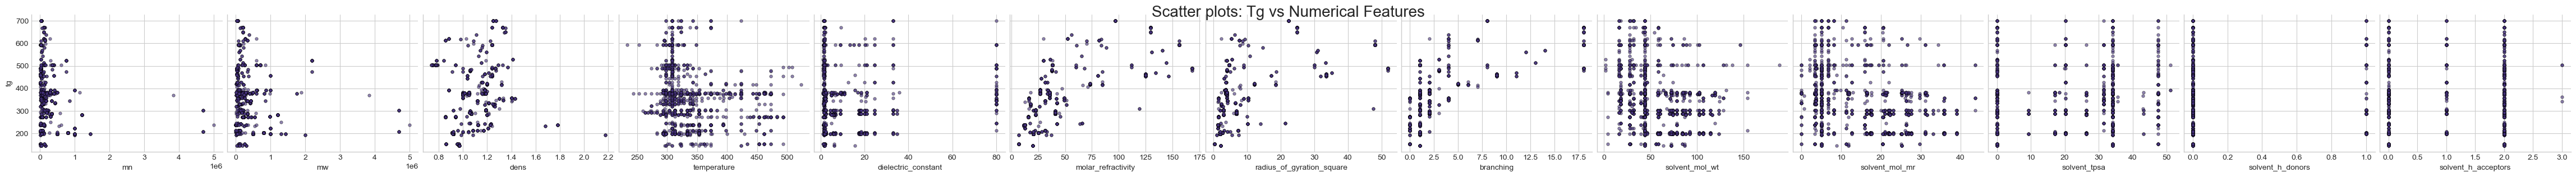

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = ['mn', 'mw', 'dens', 'temperature', 'dielectric_constant', 
                  'molar_refractivity', 'radius_of_gyration_square','branching',
                  'solvent_mol_wt','solvent_mol_mr','solvent_tpsa',
                  'solvent_h_donors','solvent_h_acceptors']

# Pairplot: Tg vs each numerical feature
sns.pairplot(df, x_vars=numerical_cols, y_vars=['tg'], 
             kind='scatter', height=3, aspect=1.2,
             plot_kws={'alpha':0.6, 's':15, 'edgecolor':'k', 'linewidth':0.5})

plt.suptitle('Scatter plots: Tg vs Numerical Features', y=1.02, fontsize=20)
plt.show()


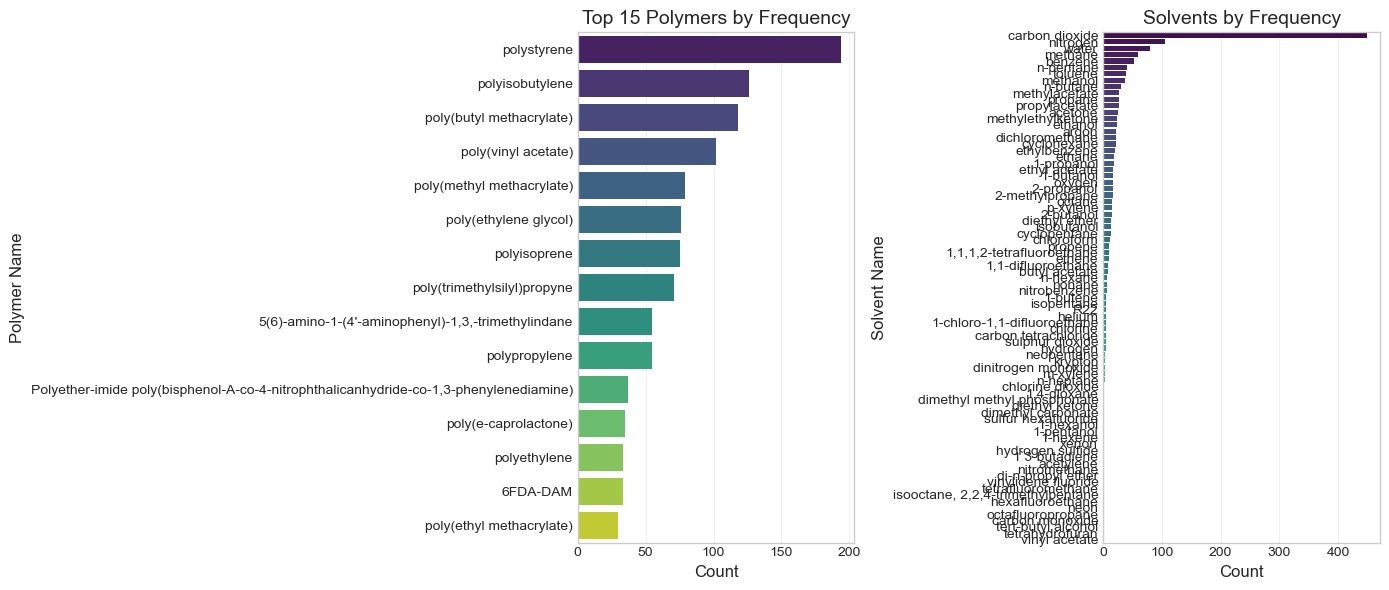

In [7]:
# Count of unique polymers and solvents
plt.figure(figsize=(14, 6))

# Top 15 polymers by frequency
plt.subplot(1, 2, 1)
top_polymers = df['polymer_name'].value_counts().nlargest(15)
sns.barplot(x=top_polymers.values, y=top_polymers.index, palette='viridis')
plt.title('Top 15 Polymers by Frequency', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Polymer Name', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Solvents by frequency
plt.subplot(1, 2, 2)
solvent_counts = df['solvent_name'].value_counts()
sns.barplot(x=solvent_counts.values, y=solvent_counts.index, palette='viridis')
plt.title('Solvents by Frequency', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Solvent Name', fontsize=12)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

### 3.1 Handling Missing Values

In [8]:
# Identify columns with missing values
columns_with_missing = missing_df[missing_df['Missing Values'] > 0].index.tolist()

if columns_with_missing:
    print(f"Columns with missing values: {columns_with_missing}")
    
    # Separate numerical and categorical columns with missing values
    numerical_cols = df[columns_with_missing].select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df[columns_with_missing].select_dtypes(include=['object']).columns.tolist()
    
    # For numerical columns, use KNN imputation
    if numerical_cols:
        print(f"\nImputing numerical columns: {numerical_cols}")
        # Create a copy of the dataframe for imputation
        df_numeric = df.copy()
        
        # Select only numeric columns for KNN imputation
        numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        
        # Apply KNN imputation
        imputer = KNNImputer(n_neighbors=5)
        df_numeric[numeric_features] = imputer.fit_transform(df[numeric_features])
        
        # Update the original dataframe with imputed values
        for col in numerical_cols:
            df[col] = df_numeric[col]
    
    # For categorical columns, use mode imputation
    if categorical_cols:
        print(f"\nImputing categorical columns: {categorical_cols}")
        for col in categorical_cols:
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
            print(f"  - {col}: Filled with mode value '{mode_value}'")
else:
    print("No missing values found in the dataset.")

Columns with missing values: ['dielectric_constant']

Imputing numerical columns: ['dielectric_constant']


### 3.2 Checking for Duplicates

In [9]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    # Remove duplicates
    df = df.drop_duplicates()
    print(f"Duplicates removed. New dataset shape: {df.shape}")

Number of duplicate rows: 27
Duplicates removed. New dataset shape: (1472, 19)


### 3.3 Outlier Detection and Handling

We'll use multiple methods to detect outliers in the numerical features.

In [10]:
# Select numerical columns for outlier detection
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create a copy of the dataframe for outlier analysis
df_outlier = df.copy()

# Function to detect outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Function to detect outliers using Z-score method
def detect_outliers_zscore(df, column, threshold=3):
    iqr_outliers, lower, upper = detect_outliers_iqr(df, column)
    iqr_count = len(iqr_outliers)
    z_scores = np.abs(stats.zscore(df[column]))
    outliers = df[z_scores > threshold]
    return outliers

# Analyze outliers for each numerical column
outlier_summary = {}

for col in numerical_cols:
    # Skip non-continuous variables
    if df[col].nunique() < 10:
        continue
        
    # IQR method
    iqr_outliers, lower, upper = detect_outliers_iqr(df, col)
    iqr_count = len(iqr_outliers)
    
    # Z-score method
    zscore_outliers = detect_outliers_zscore(df, col)
    zscore_count = len(zscore_outliers)
    
    # Store results
    outlier_summary[col] = {
        'IQR': iqr_count,
        'Z-score': zscore_count,
        'IQR_bounds': (lower, upper)
    }

# Display outlier summary
outlier_df = pd.DataFrame({
    'IQR Method': [outlier_summary[col]['IQR'] for col in outlier_summary],
    'Z-score Method': [outlier_summary[col]['Z-score'] for col in outlier_summary],
    'IQR Lower Bound': [outlier_summary[col]['IQR_bounds'][0] for col in outlier_summary],
    'IQR Upper Bound': [outlier_summary[col]['IQR_bounds'][1] for col in outlier_summary]
}, index=outlier_summary.keys())

print("Outlier Detection Summary:")
outlier_df

Outlier Detection Summary:


IQR Method  Z-score Method  IQR Lower Bound  \
mn                                143              10   -405500.000000   
mw                                107              24   -414062.500000   
tg                                 52               0         5.500000   
dens                               13              13         0.557500   
temperature                       161              15       240.575000   
dielectric_constant               279              78        -5.000000   
molar_refractivity                221              37        -9.777500   
radius_of_gyration_square         201              82        -4.328836   
branching                         263             111        -0.500000   
solvent_mol_wt                     35               7        -1.162000   
solvent_mol_mr                      0               0       -20.368200   
solvent_tpsa                        0               0       -51.210000   

                           IQR Upper Bound  
mn                           782500.000000  
mw                           926837.500000  
tg                              625.500000  
dens                              1.577500  
temperature                     420.775000  
dielectric_constant              12.600000  
molar_refractivity               70.994500  
radius_of_gyration_square        13.716862  
branching                         3.500000  
solvent_mol_wt                  119.294000  
solvent_mol_mr                   47.299000  
solvent_tpsa                     85.350000

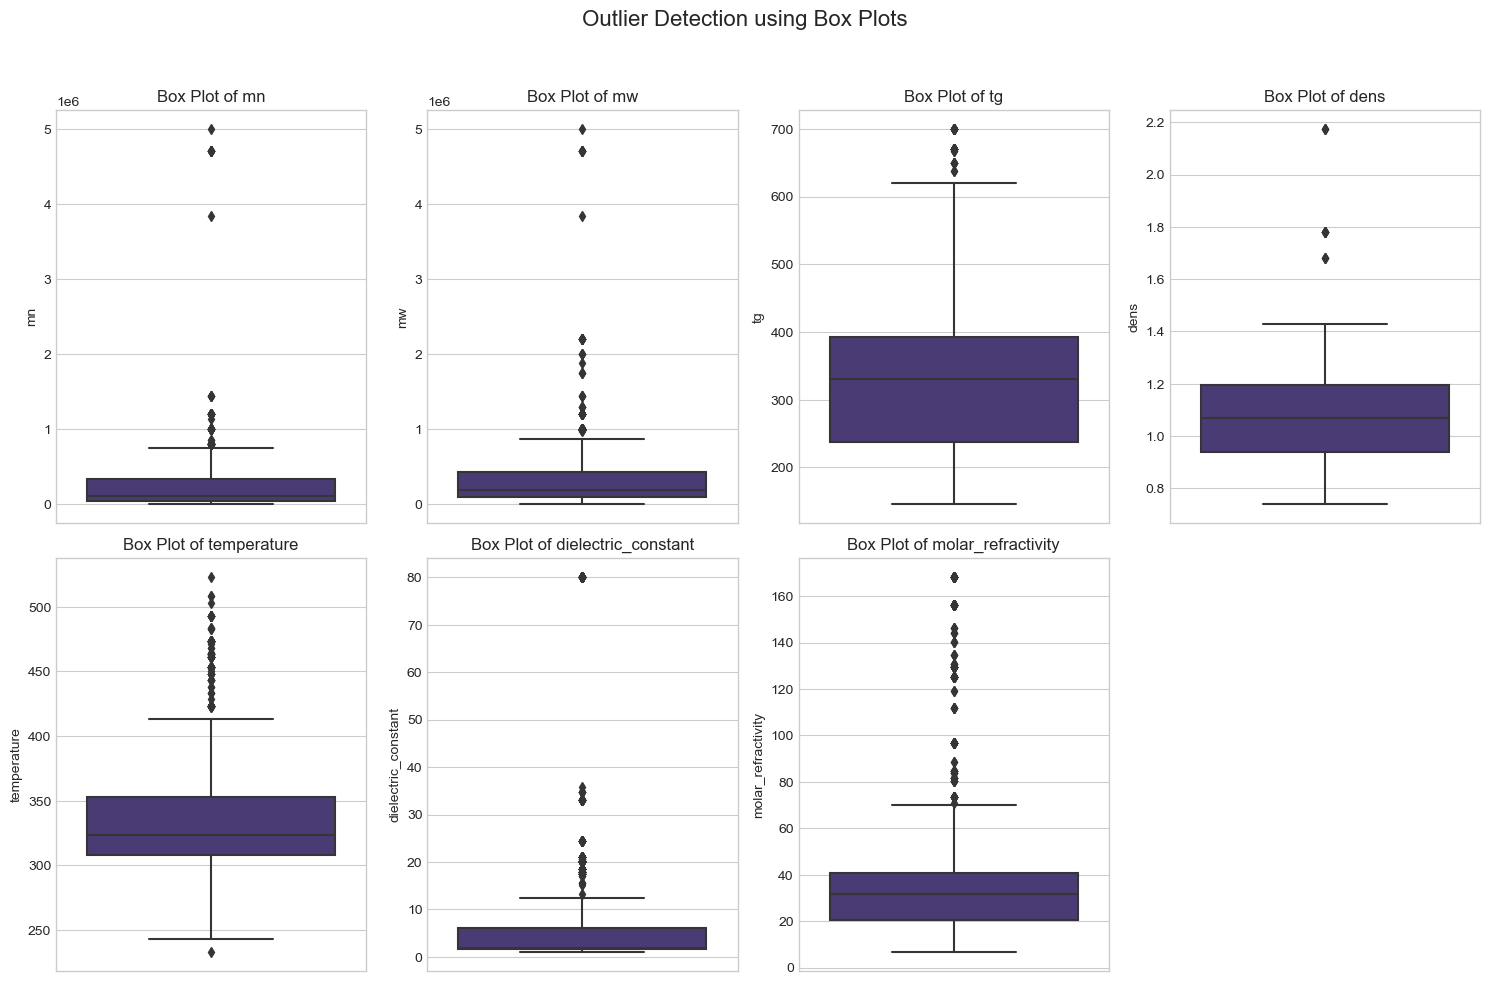

In [11]:
# Visualize outliers using box plots for key numerical features
plt.figure(figsize=(15, 10))

# Select important numerical columns for visualization
key_numerical_cols = ['mn', 'mw', 'tg', 'dens', 'temperature', 'dielectric_constant', 'branching_index', 'molar_refractivity']
key_numerical_cols = [col for col in key_numerical_cols if col in df.columns]

for i, col in enumerate(key_numerical_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.tight_layout()

plt.suptitle('Outlier Detection using Box Plots', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [12]:
# Handle outliers using capping method for extreme values
# We'll cap values at the IQR bounds to preserve data while reducing extreme values

df_cleaned = df.copy()

for col in outlier_summary:
    lower_bound = outlier_summary[col]['IQR_bounds'][0]
    upper_bound = outlier_summary[col]['IQR_bounds'][1]
    
    # Count values outside bounds
    lower_count = (df_cleaned[col] < lower_bound).sum()
    upper_count = (df_cleaned[col] > upper_bound).sum()
    
    # Only cap if outliers are less than 5% of the data
    total_outliers = lower_count + upper_count
    if total_outliers > 0 and total_outliers < 0.05 * len(df_cleaned):
        print(f"Capping outliers in {col}: {lower_count} below lower bound, {upper_count} above upper bound")
        
        # Cap values
        df_cleaned[col] = df_cleaned[col].clip(lower=lower_bound, upper=upper_bound)
    elif total_outliers >= 0.05 * len(df_cleaned):
        print(f"Not capping {col}: too many outliers ({total_outliers}, {total_outliers/len(df_cleaned)*100:.2f}%)")

# Use the cleaned dataframe for further analysis
df = df_cleaned

Not capping mn: too many outliers (143, 9.71%)
Not capping mw: too many outliers (107, 7.27%)
Capping outliers in tg: 0 below lower bound, 52 above upper bound
Capping outliers in dens: 0 below lower bound, 13 above upper bound
Not capping temperature: too many outliers (161, 10.94%)
Not capping dielectric_constant: too many outliers (279, 18.95%)
Not capping molar_refractivity: too many outliers (221, 15.01%)
Not capping radius_of_gyration_square: too many outliers (201, 13.65%)
Not capping branching: too many outliers (263, 17.87%)
Capping outliers in solvent_mol_wt: 0 below lower bound, 35 above upper bound


### 3.4 Scaling and Standardization

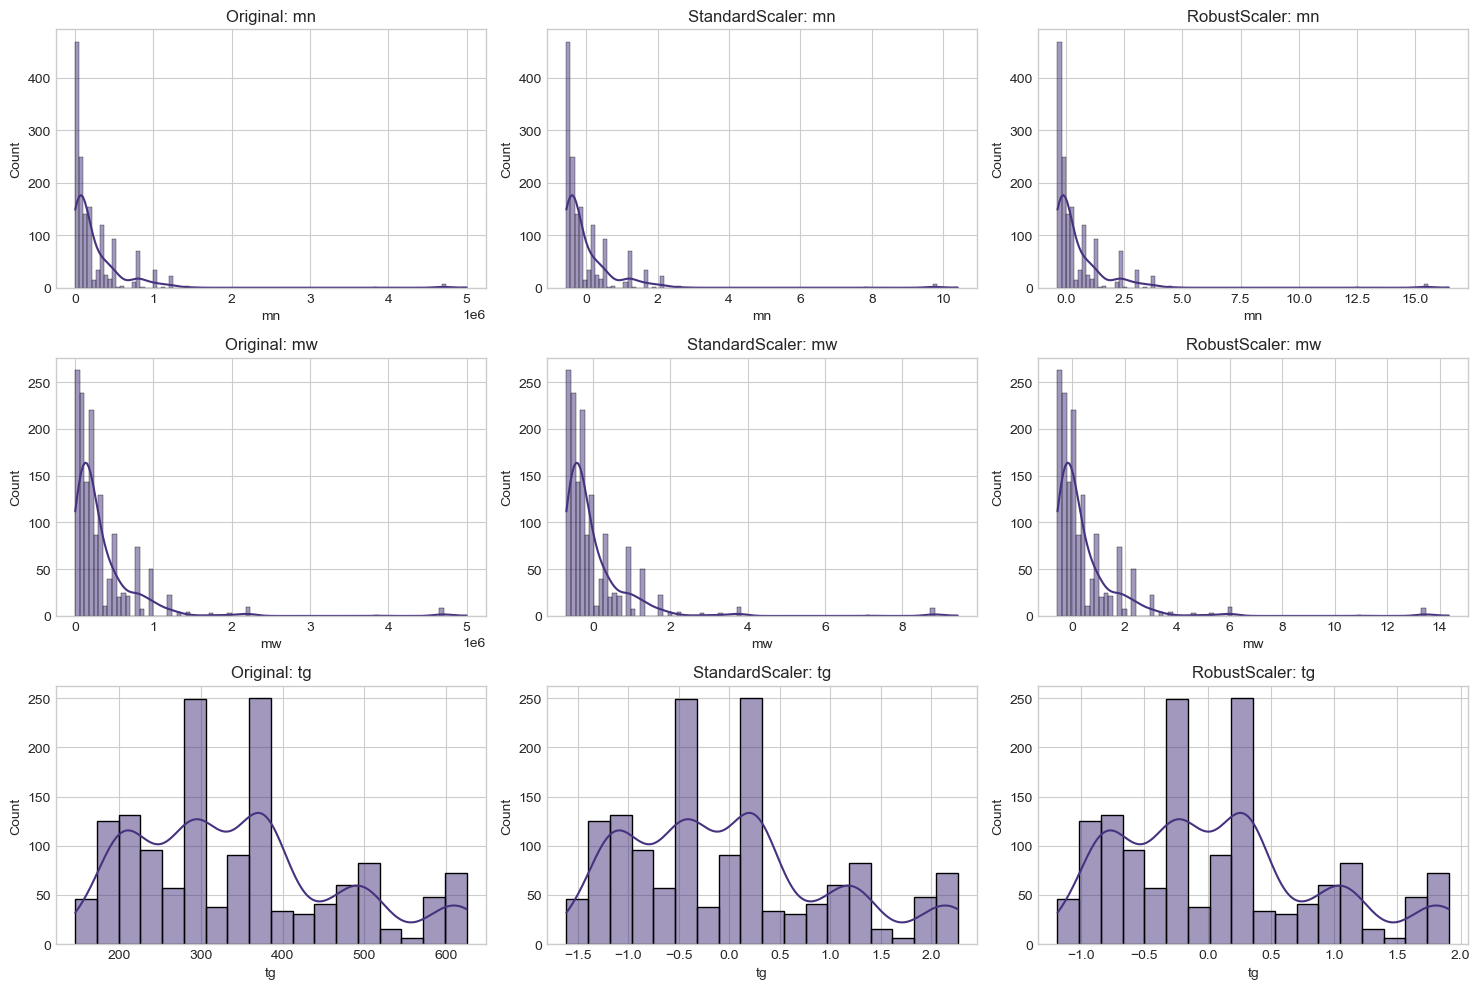

In [13]:
# Select numerical columns for scaling
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create copies of the dataframe with different scaling methods
df_standard = df.copy()
df_minmax = df.copy()
df_robust = df.copy()

# Apply StandardScaler
std_scaler = StandardScaler()
df_standard[numerical_cols] = std_scaler.fit_transform(df[numerical_cols])

# Apply MinMaxScaler
minmax_scaler = MinMaxScaler()
df_minmax[numerical_cols] = minmax_scaler.fit_transform(df[numerical_cols])

# Apply RobustScaler (less sensitive to outliers)
robust_scaler = RobustScaler()
df_robust[numerical_cols] = robust_scaler.fit_transform(df[numerical_cols])

# Compare the scaling methods for a few columns
sample_cols = ['mn', 'mw', 'tg'] if all(col in numerical_cols for col in ['mn', 'mw', 'tg']) else numerical_cols[:3]

plt.figure(figsize=(15, 10))

for i, col in enumerate(sample_cols):
    plt.subplot(3, 3, i*3+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Original: {col}')
    
    plt.subplot(3, 3, i*3+2)
    sns.histplot(df_standard[col], kde=True)
    plt.title(f'StandardScaler: {col}')
    
    plt.subplot(3, 3, i*3+3)
    sns.histplot(df_robust[col], kde=True)
    plt.title(f'RobustScaler: {col}')

plt.tight_layout()
plt.show()

# Based on the presence of outliers, we'll use RobustScaler for further analysis
# as it's less sensitive to outliers
df_scaled = df_robust

## 4. Exploratory Data Analysis (EDA)

### 4.1 Univariate Analysis

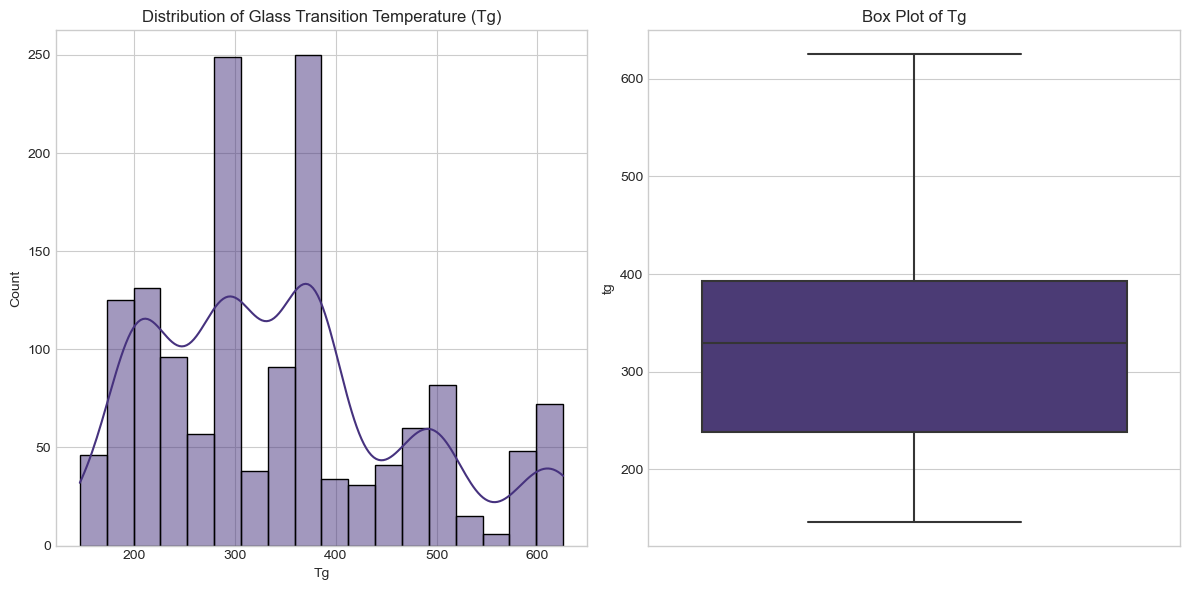

Tg Skewness: 0.6054
Tg Kurtosis: -0.3723


In [14]:
# Analyze the distribution of the target variable (Tg)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['tg'], kde=True)
plt.title('Distribution of Glass Transition Temperature (Tg)')
plt.xlabel('Tg')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['tg'])
plt.title('Box Plot of Tg')

plt.tight_layout()
plt.show()

# Calculate skewness and kurtosis of Tg
tg_skewness = df['tg'].skew()
tg_kurtosis = df['tg'].kurt()

print(f"Tg Skewness: {tg_skewness:.4f}")
print(f"Tg Kurtosis: {tg_kurtosis:.4f}")

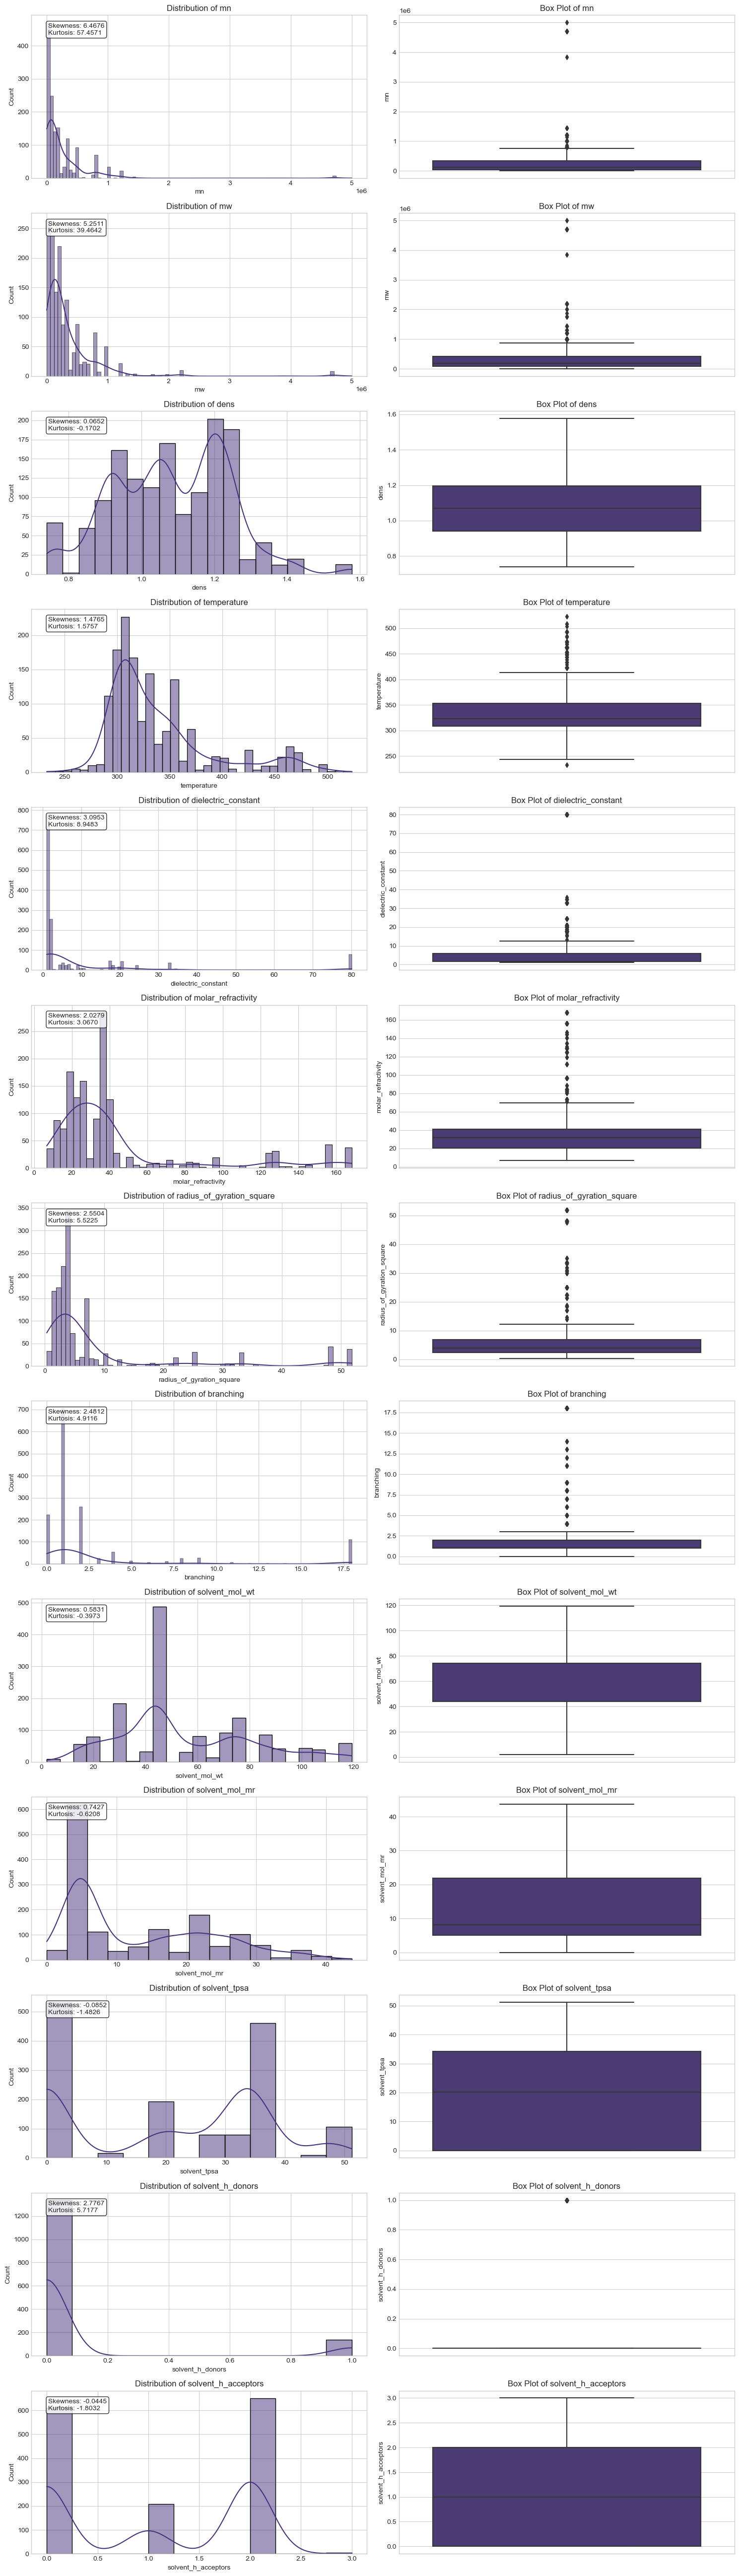

In [15]:
# Analyze distributions of key numerical features
numerical_features = ['mn', 'mw', 'dens', 'temperature', 'dielectric_constant', 
                  'molar_refractivity', 'radius_of_gyration_square','branching',
                  'solvent_mol_wt','solvent_mol_mr','solvent_tpsa',
                  'solvent_h_donors','solvent_h_acceptors']
numerical_features = [col for col in numerical_features if col in df.columns]

# Create histograms and density plots
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(15, 4*len(numerical_features)))

for i, feature in enumerate(numerical_features):
    # Histogram with KDE
    sns.histplot(df[feature], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {feature}')
    
    # Box plot
    sns.boxplot(y=df[feature], ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {feature}')
    
    # Calculate and display skewness and kurtosis
    skewness = df[feature].skew()
    kurtosis = df[feature].kurt()
    axes[i, 0].text(0.05, 0.95, f"Skewness: {skewness:.4f}\nKurtosis: {kurtosis:.4f}", 
                   transform=axes[i, 0].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### 4.2 Bivariate and Multivariate Analysis

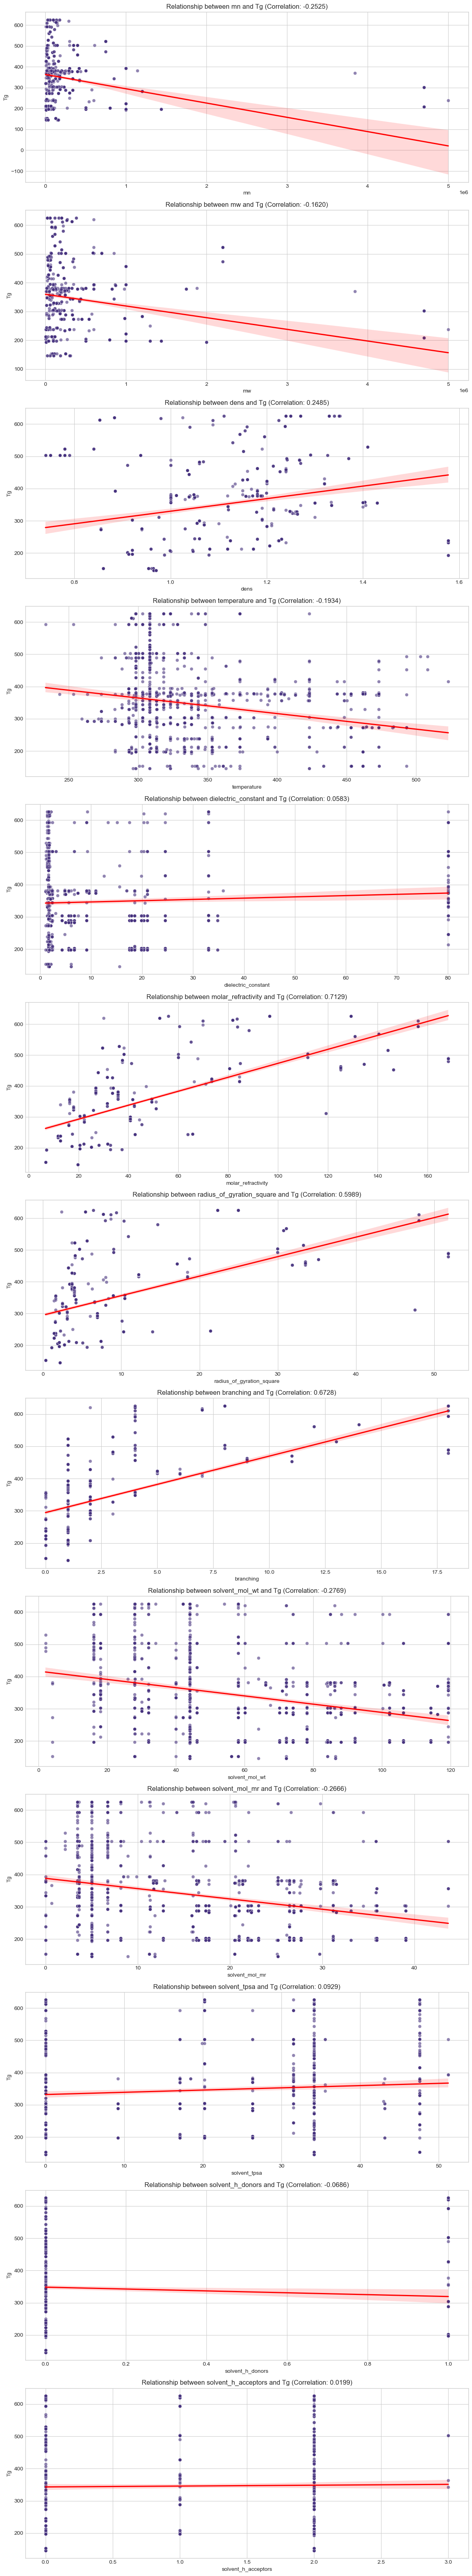

In [16]:
# Analyze relationships between numerical features and Tg
numerical_features = [col for col in numerical_cols if col != 'tg']

# Create scatter plots for each numerical feature vs Tg
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(12, 5*len(numerical_features)))

for i, feature in enumerate(numerical_features):
    sns.scatterplot(x=df[feature], y=df['tg'], alpha=0.6, ax=axes[i])
    
    # Add regression line
    sns.regplot(x=df[feature], y=df['tg'], scatter=False, ax=axes[i], color='red')
    
    # Calculate correlation coefficient
    corr = df[[feature, 'tg']].corr().iloc[0, 1]
    axes[i].set_title(f'Relationship between {feature} and Tg (Correlation: {corr:.4f})')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Tg')

plt.tight_layout()
plt.show()

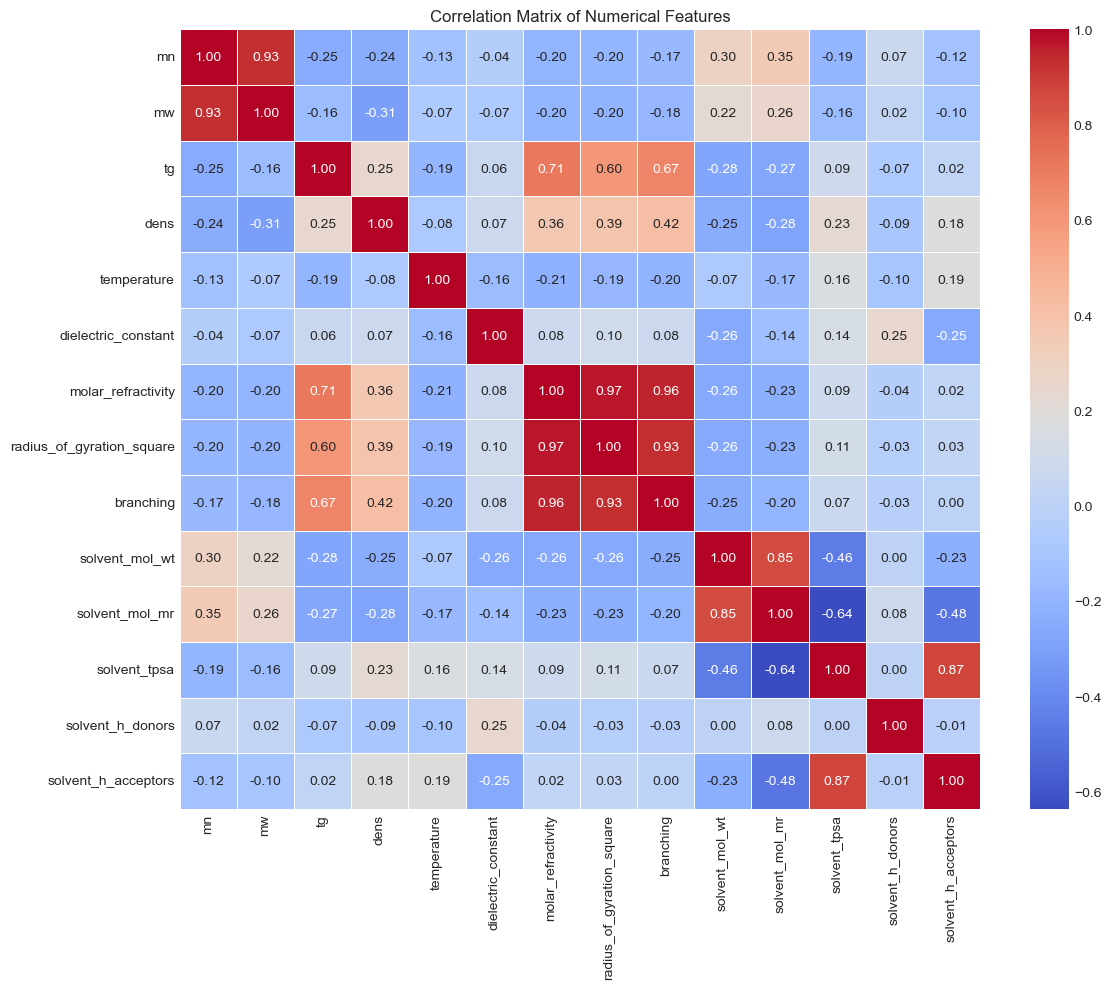

Highly correlated features (|correlation| > 0.7):
mw and mn: 0.9308
molar_refractivity and tg: 0.7129
radius_of_gyration_square and molar_refractivity: 0.9706
branching and molar_refractivity: 0.9552
branching and radius_of_gyration_square: 0.9306
solvent_mol_mr and solvent_mol_wt: 0.8533
solvent_h_acceptors and solvent_tpsa: 0.8737


In [17]:
# Correlation matrix for numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
correlation_matrix = df[numerical_features].corr()

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Identify highly correlated features (|correlation| > 0.7)
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

if high_corr:
    print("Highly correlated features (|correlation| > 0.7):")
    for feat1, feat2, corr in high_corr:
        print(f"{feat1} and {feat2}: {corr:.4f}")
else:
    print("No highly correlated features found (|correlation| > 0.7).")

## 5. Skewness Analysis and Transformations

Skewness of numerical features:
mn                           6.467605
mw                           5.251091
dielectric_constant          3.095331
solvent_h_donors             2.776673
radius_of_gyration_square    2.550417
branching                    2.481153
molar_refractivity           2.027884
temperature                  1.476450
solvent_mol_mr               0.742671
tg                           0.605403
solvent_mol_wt               0.583059
dens                         0.065224
solvent_h_acceptors         -0.044507
solvent_tpsa                -0.085210
dtype: float64

Highly skewed features (|skewness| > 1): ['mn', 'mw', 'dielectric_constant', 'solvent_h_donors', 'radius_of_gyration_square', 'branching', 'molar_refractivity', 'temperature']
Applied Box-Cox transformation to mn
Applied Box-Cox transformation to mw
Applied Box-Cox transformation to dielectric_constant
Applied log transformation to solvent_h_donors with offset 1
Applied Box-Cox transformation to radius_of_gyration_sq

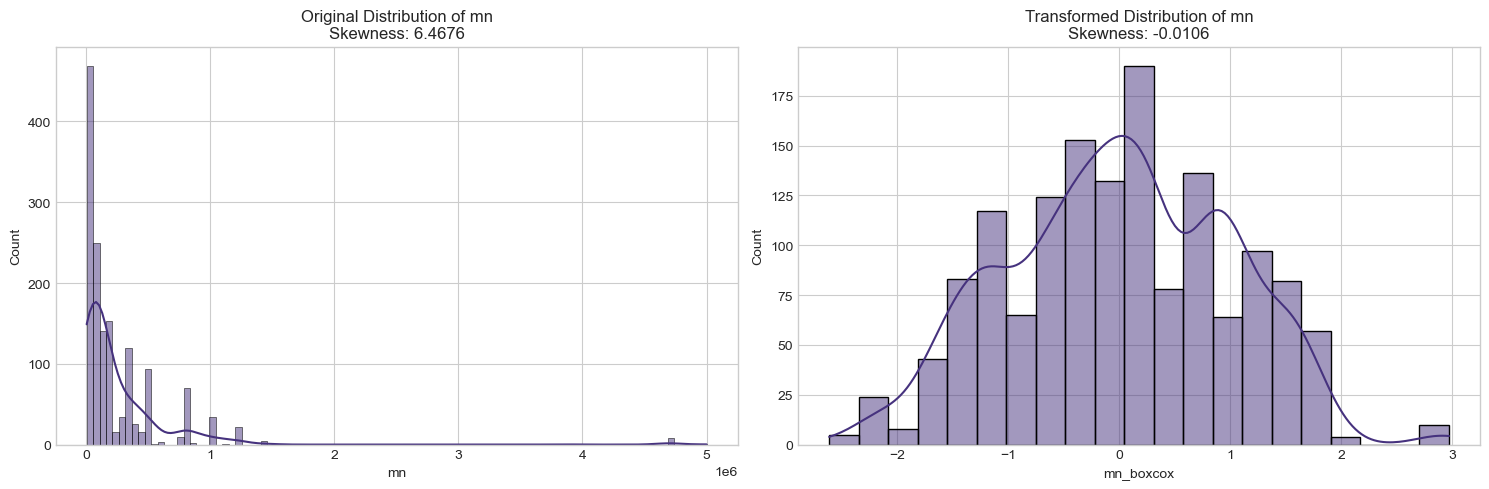

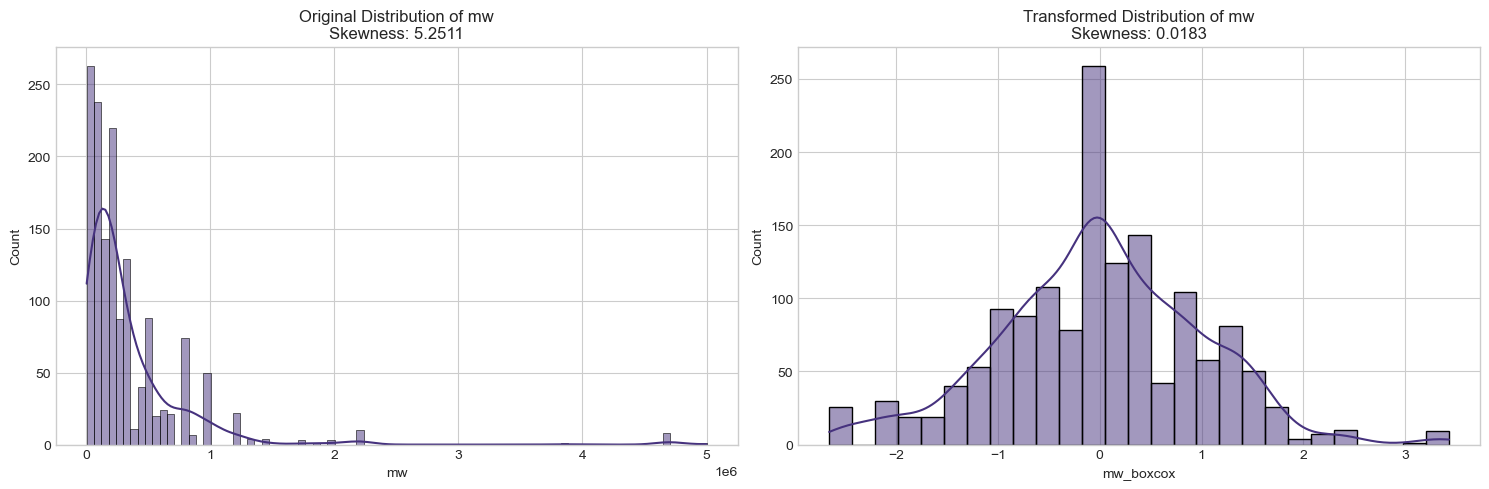

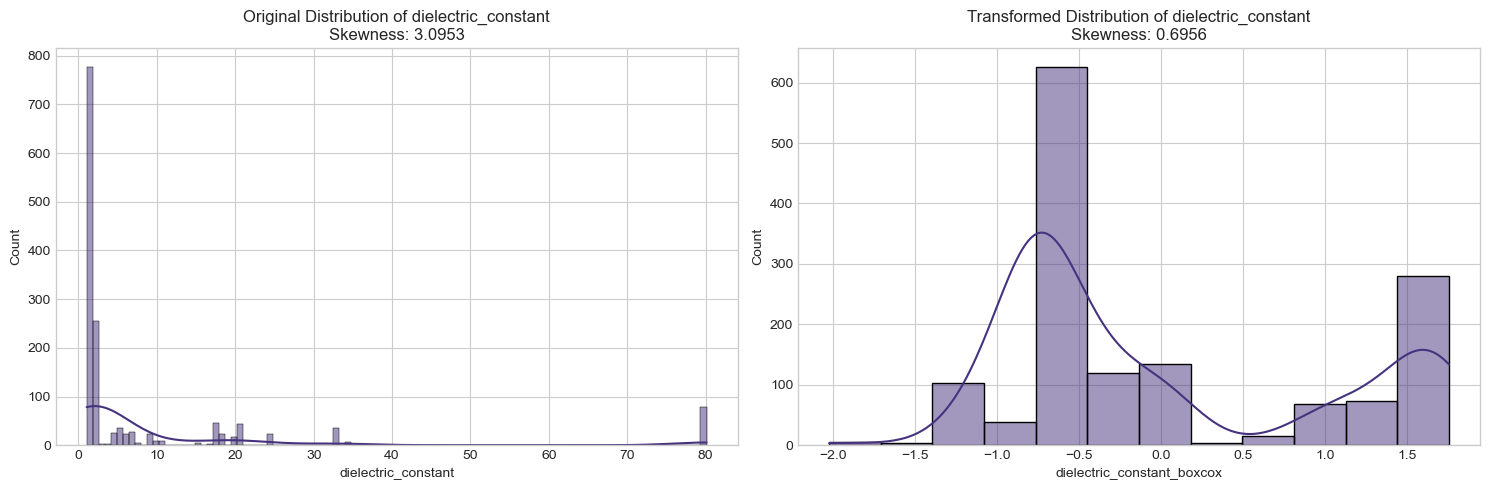

In [18]:
# Calculate skewness for numerical features
skewness = df[numerical_features].skew().sort_values(ascending=False)

print("Skewness of numerical features:")
print(skewness)

# Identify highly skewed features (|skewness| > 1)
highly_skewed = skewness[abs(skewness) > 1].index.tolist()

if highly_skewed:
    print(f"\nHighly skewed features (|skewness| > 1): {highly_skewed}")
    
    # Apply transformations to reduce skewness
    df_transformed = df.copy()
    
    # Apply Box-Cox transformation (requires positive values)
    pt = PowerTransformer(method='box-cox')
    
    for feature in highly_skewed:
        # Skip the target variable
        if feature == 'tg':
            continue
            
        # Check if all values are positive
        if (df[feature] <= 0).any():
            # Apply log transformation with offset for non-positive values
            min_val = df[feature].min()
            if min_val <= 0:
                offset = abs(min_val) + 1
                df_transformed[f"{feature}_log"] = np.log(df[feature] + offset)
                print(f"Applied log transformation to {feature} with offset {offset}")
            else:
                df_transformed[f"{feature}_log"] = np.log(df[feature])
                print(f"Applied log transformation to {feature}")
        else:
            # Apply Box-Cox transformation
            try:
                df_transformed[f"{feature}_boxcox"] = pt.fit_transform(df[[feature]])
                print(f"Applied Box-Cox transformation to {feature}")
            except Exception as e:
                print(f"Error applying Box-Cox to {feature}: {e}")
                # Fallback to log transformation
                df_transformed[f"{feature}_log"] = np.log(df[feature])
                print(f"Applied log transformation to {feature} instead")
    
    # Compare original and transformed distributions for a few features
    for feature in highly_skewed[:3]:  # Show first 3 for brevity
        if feature == 'tg':
            continue
            
        plt.figure(figsize=(15, 5))
        
        # Original distribution
        plt.subplot(1, 2, 1)
        sns.histplot(df[feature], kde=True)
        plt.title(f'Original Distribution of {feature}\nSkewness: {df[feature].skew():.4f}')
        
        # Transformed distribution
        transformed_col = next((col for col in df_transformed.columns if col.startswith(f"{feature}_")), None)
        if transformed_col:
            plt.subplot(1, 2, 2)
            sns.histplot(df_transformed[transformed_col], kde=True)
            plt.title(f'Transformed Distribution of {feature}\nSkewness: {df_transformed[transformed_col].skew():.4f}')
        
        plt.tight_layout()
        plt.show()
else:
    print("No highly skewed features found (|skewness| > 1).")

## 6. Solvent-Specific Analysis

In this section, we'll focus specifically on analyzing how different solvents affect the glass transition temperature (Tg).

In [19]:
# Group data by solvent and analyze Tg statistics
solvent_tg_stats = df.groupby('solvent_name')['tg'].agg([
    'count', 'mean', 'std', 'min', 'max',
    lambda x: x.max() - x.min()  # Range
]).rename(columns={'<lambda_0>': 'range'}).sort_values('mean', ascending=False)

# Calculate coefficient of variation (CV) for each solvent
solvent_tg_stats['cv'] = solvent_tg_stats['std'] / solvent_tg_stats['mean'] * 100

# Display solvent statistics
print("Solvent Effects on Glass Transition Temperature (Tg):")
solvent_tg_stats

Solvent Effects on Glass Transition Temperature (Tg):


count     mean         std     min    max   range  \
solvent_name                                                             
1`3-butadiene            1  625.500         NaN  625.50  625.5    0.00   
1-hexanol                1  593.000         NaN  593.00  593.0    0.00   
sulfur hexafluoride      2  593.000    0.000000  593.00  593.0    0.00   
1-pentanol               1  593.000         NaN  593.00  593.0    0.00   
hydrogen sulfide         2  564.325   86.514515  503.15  625.5  122.35   
...                    ...      ...         ...     ...    ...     ...   
isopentane               5  224.720   88.343262  153.00  379.0  226.00   
R22                      5  219.800  105.084252  146.00  381.0  235.00   
neopentane               3  197.200    0.000000  197.20  197.2    0.00   
1-butene                 5  153.000    0.000000  153.00  153.0    0.00   
1-hexene                 2  153.000    0.000000  153.00  153.0    0.00   

                            cv  
solvent_name                    
1`3-butadiene              NaN  
1-hexanol                  NaN  
sulfur hexafluoride   0.000000  
1-pentanol                 NaN  
hydrogen sulfide     15.330619  
...                        ...  
isopentane           39.312594  
R22                  47.809032  
neopentane            0.000000  
1-butene              0.000000  
1-hexene              0.000000  

[80 rows x 7 columns]

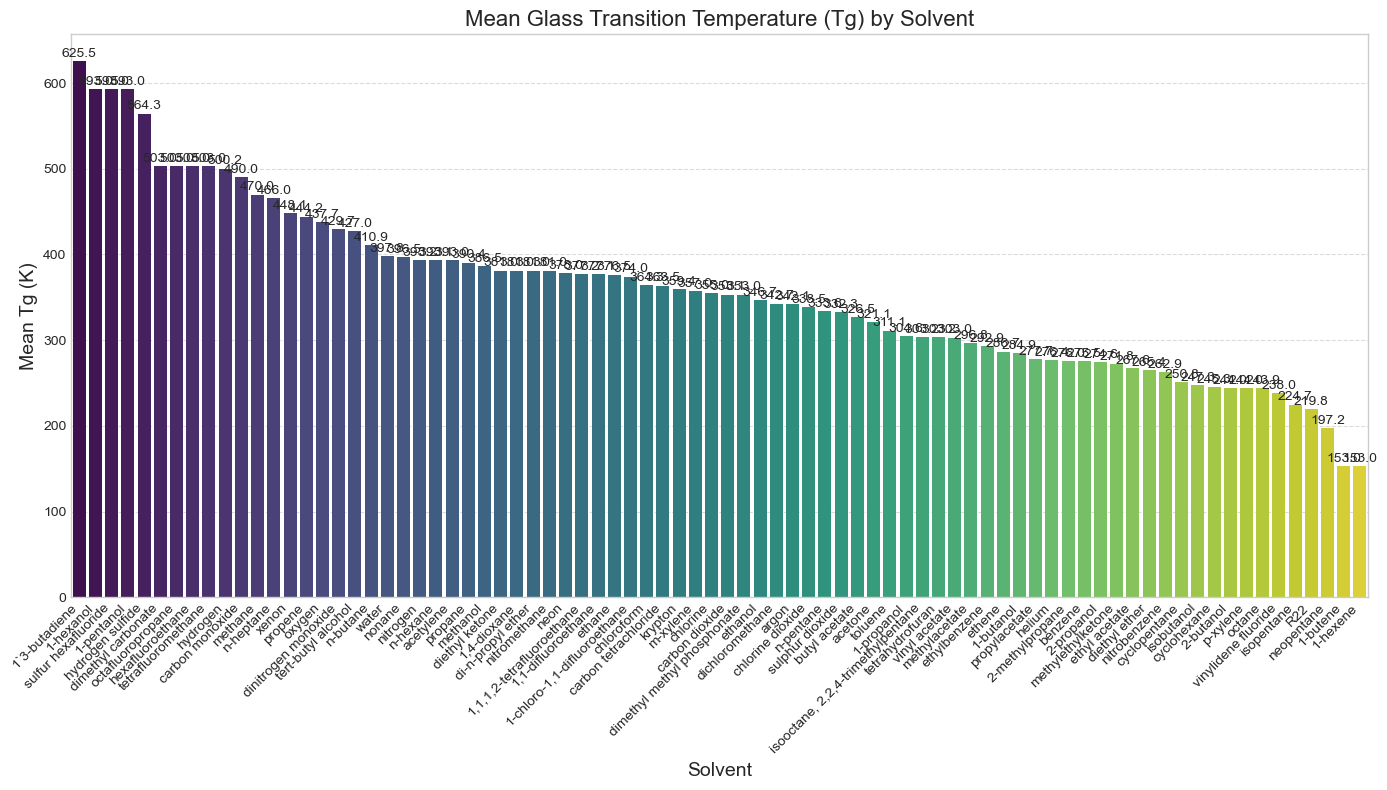

In [20]:
# Visualize mean Tg by solvent
plt.figure(figsize=(14, 8))
sns.barplot(x=solvent_tg_stats.index, y=solvent_tg_stats['mean'], palette='viridis')
plt.title('Mean Glass Transition Temperature (Tg) by Solvent', fontsize=16)
plt.xlabel('Solvent', fontsize=14)
plt.ylabel('Mean Tg (K)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, v in enumerate(solvent_tg_stats['mean']):
    plt.text(i, v + 5, f"{v:.1f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

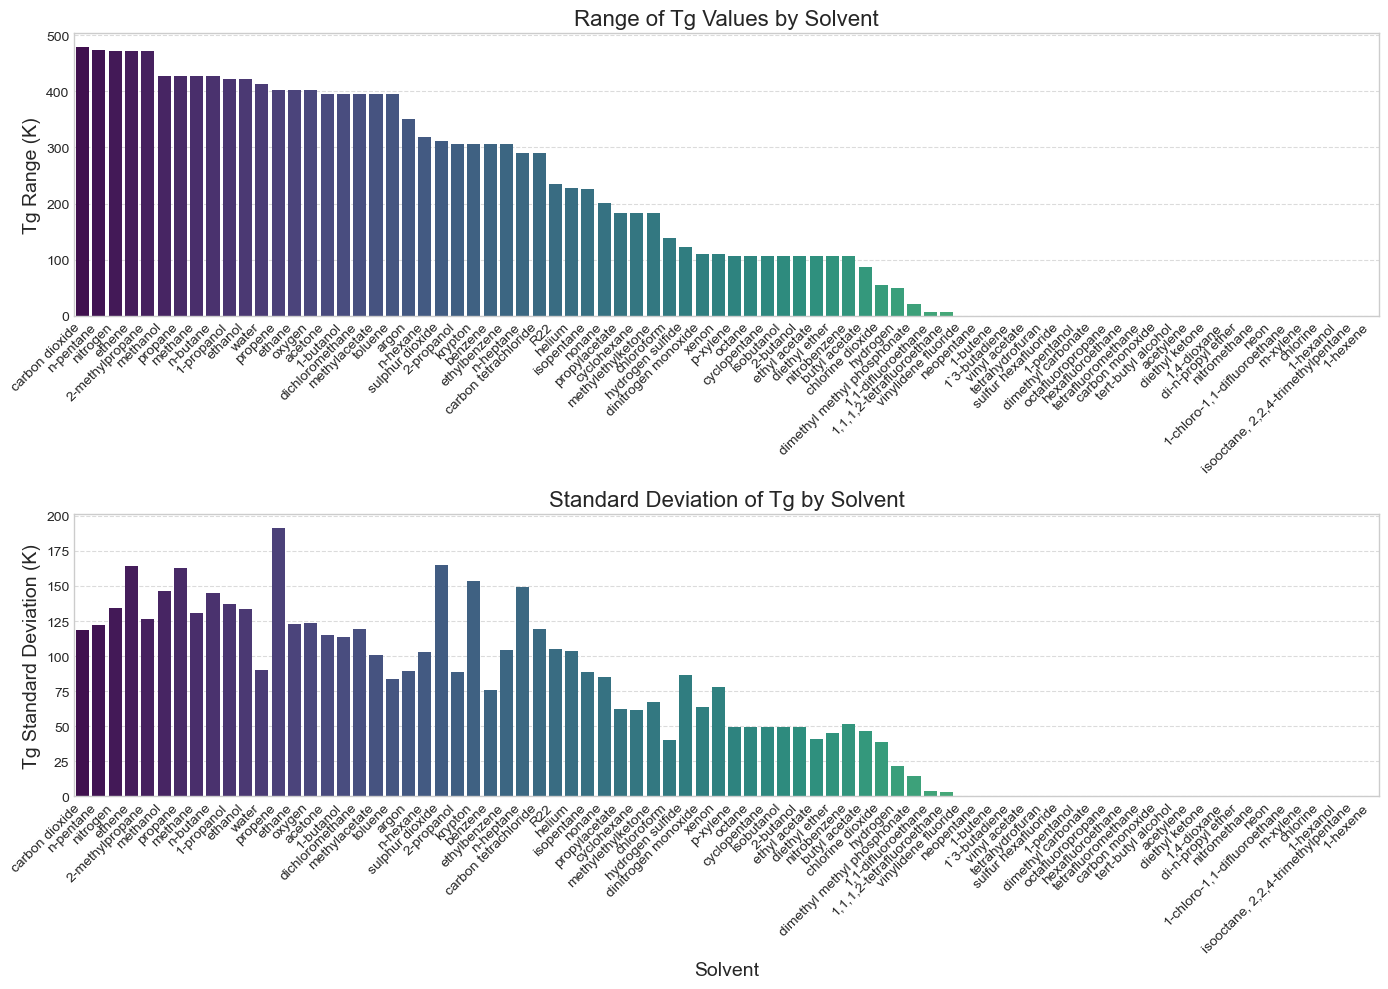

In [21]:
# Visualize Tg range and standard deviation by solvent
plt.figure(figsize=(14, 10))

# Sort by range for this visualization
sorted_by_range = solvent_tg_stats.sort_values('range', ascending=False)

# Plot range
plt.subplot(2, 1, 1)
sns.barplot(x=sorted_by_range.index, y=sorted_by_range['range'], palette='viridis')
plt.title('Range of Tg Values by Solvent', fontsize=16)
plt.xlabel('')
plt.ylabel('Tg Range (K)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot standard deviation
plt.subplot(2, 1, 2)
sns.barplot(x=sorted_by_range.index, y=sorted_by_range['std'], palette='viridis')
plt.title('Standard Deviation of Tg by Solvent', fontsize=16)
plt.xlabel('Solvent', fontsize=14)
plt.ylabel('Tg Standard Deviation (K)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

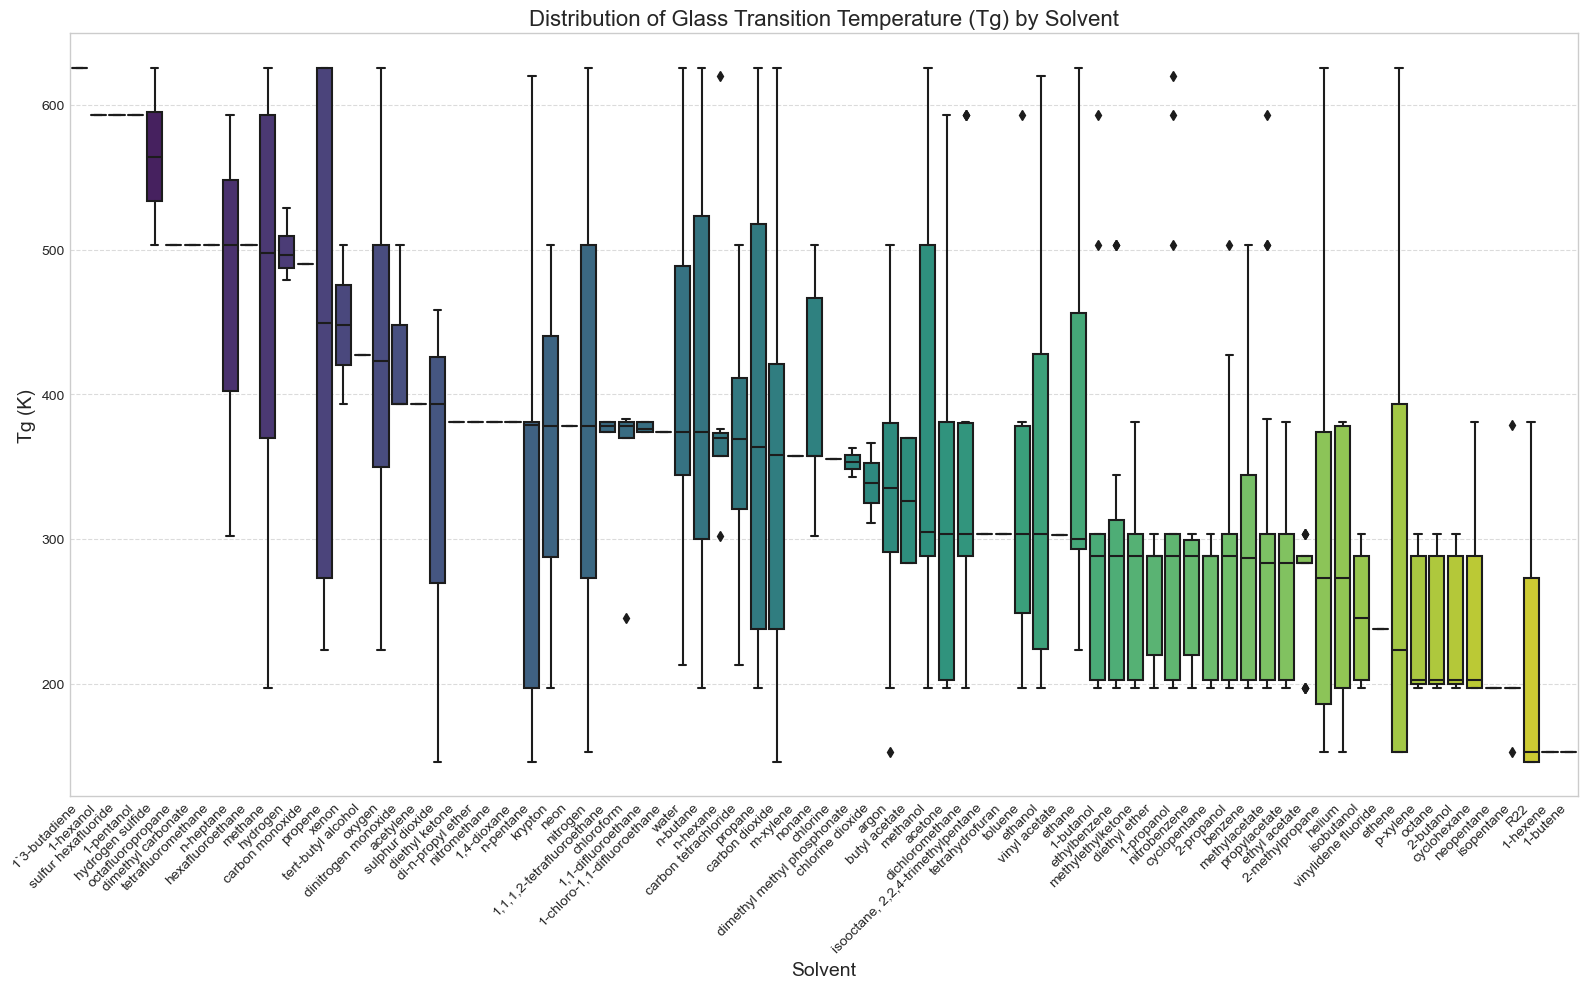

In [22]:
# Create box plots to visualize Tg distribution by solvent
plt.figure(figsize=(16, 10))

# Sort solvents by median Tg
solvent_order = df.groupby('solvent_name')['tg'].median().sort_values(ascending=False).index

# Create box plot
sns.boxplot(x='solvent_name', y='tg', data=df, order=solvent_order, palette='viridis')
plt.title('Distribution of Glass Transition Temperature (Tg) by Solvent', fontsize=16)
plt.xlabel('Solvent', fontsize=14)
plt.ylabel('Tg (K)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

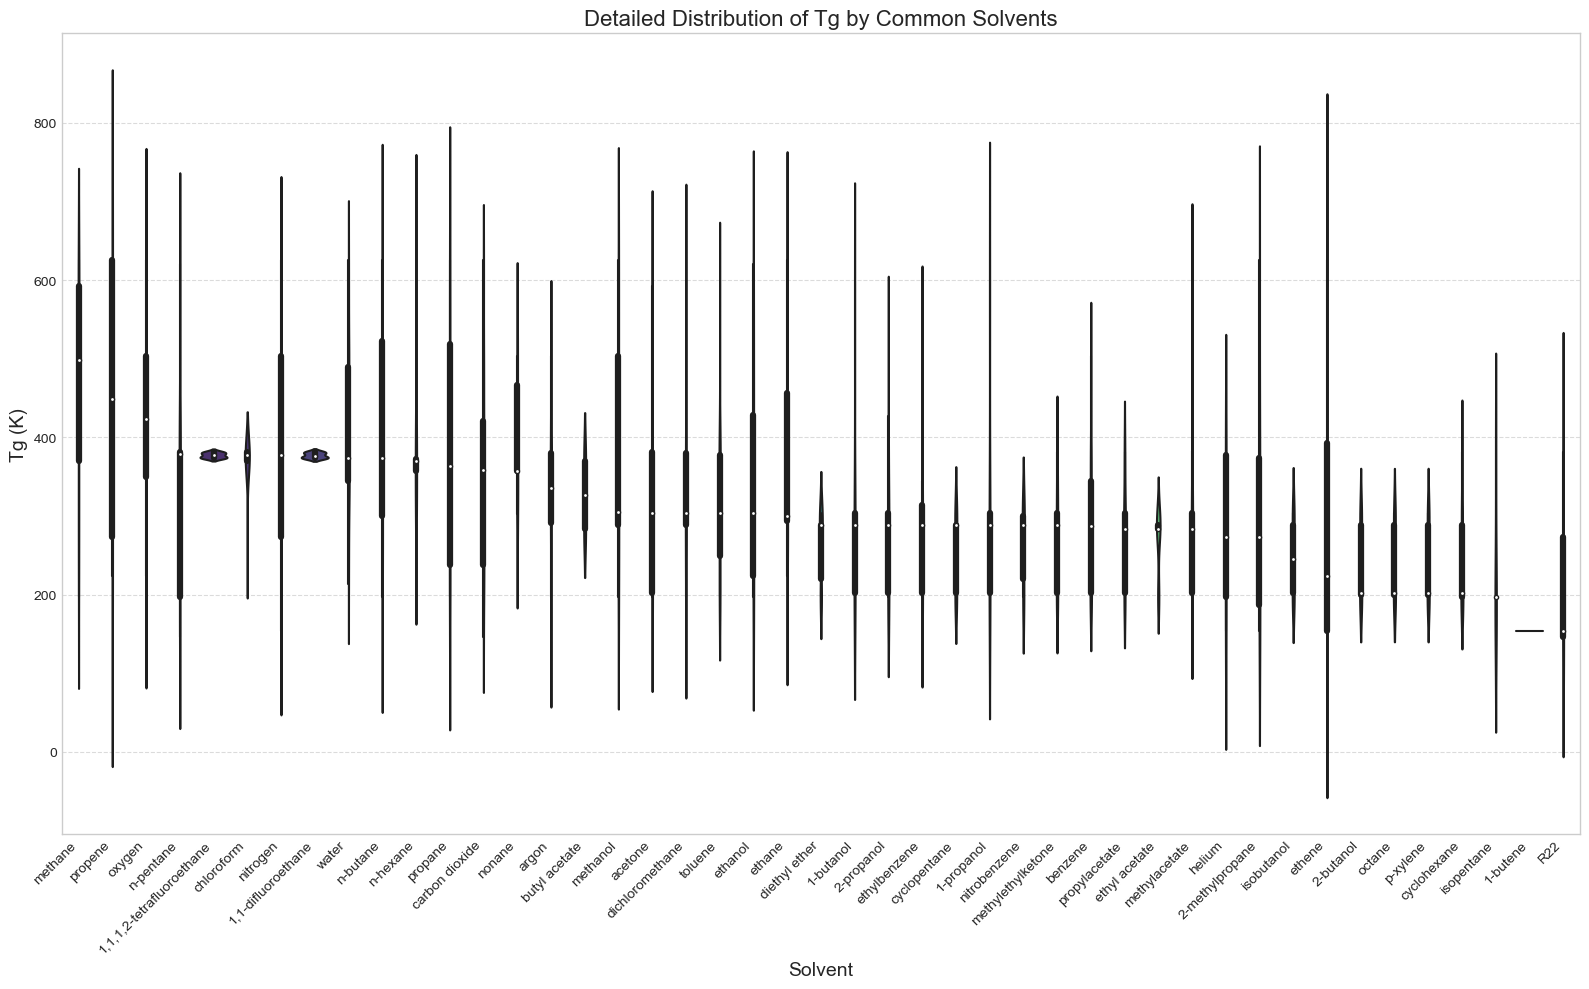

In [23]:
# Create violin plots for more detailed distribution visualization
plt.figure(figsize=(16, 10))

# Filter to include only solvents with sufficient data points
solvent_counts = df['solvent_name'].value_counts()
common_solvents = solvent_counts[solvent_counts >= 5].index.tolist()

if common_solvents:
    # Filter data for common solvents
    common_solvent_data = df[df['solvent_name'].isin(common_solvents)]
    
    # Sort by median Tg
    solvent_order = common_solvent_data.groupby('solvent_name')['tg'].median().sort_values(ascending=False).index
    
    # Create violin plot
    sns.violinplot(x='solvent_name', y='tg', data=common_solvent_data, order=solvent_order, palette='viridis', inner='box')
    plt.title('Detailed Distribution of Tg by Common Solvents', fontsize=16)
    plt.xlabel('Solvent', fontsize=14)
    plt.ylabel('Tg (K)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
else:
    plt.text(0.5, 0.5, "Insufficient data for violin plots\n(requires at least 5 data points per solvent)", 
             ha='center', va='center', fontsize=14)

plt.tight_layout()
plt.show()

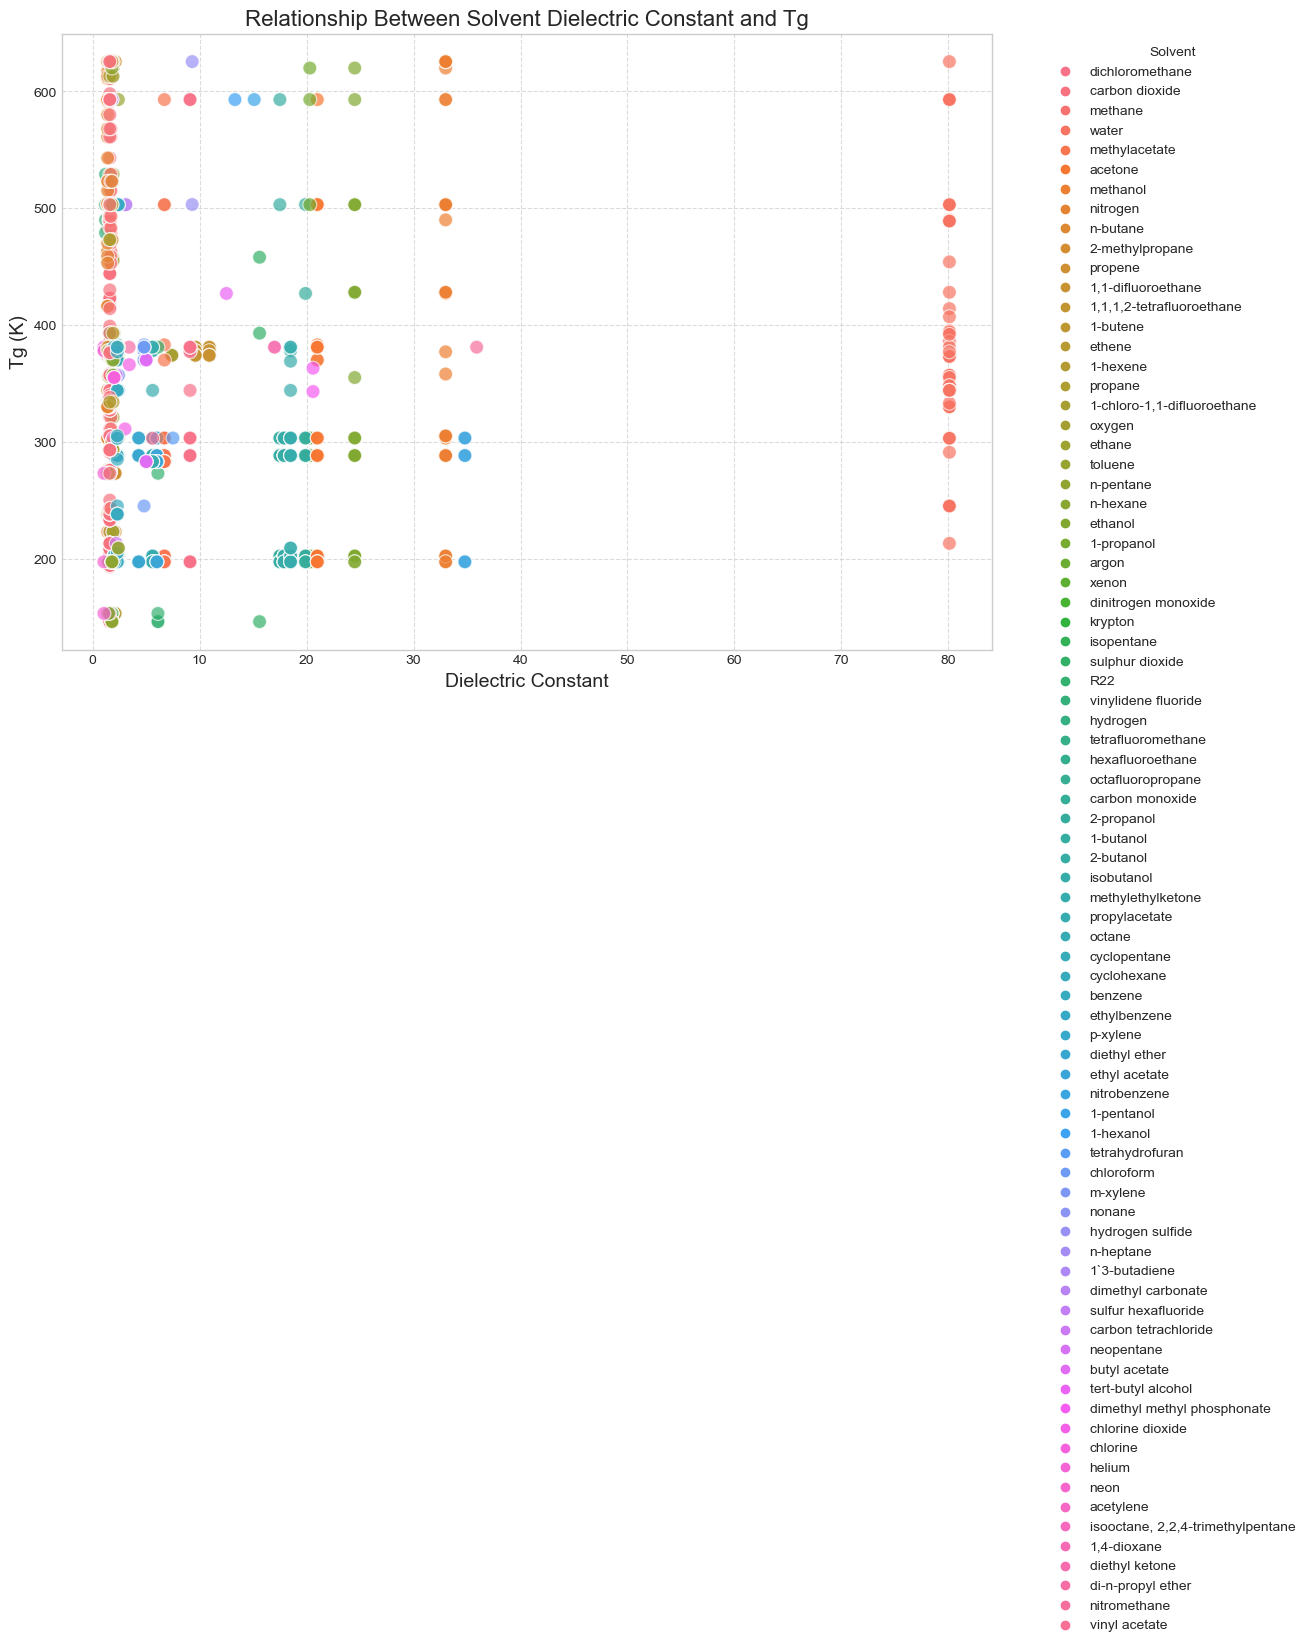

In [24]:
# Analyze relationship between solvent dielectric constant and Tg
plt.figure(figsize=(12, 8))

# Create scatter plot
sns.scatterplot(x='dielectric_constant', y='tg', hue='solvent_name', data=df, s=100, alpha=0.7)
plt.title('Relationship Between Solvent Dielectric Constant and Tg', fontsize=16)
plt.xlabel('Dielectric Constant', fontsize=14)
plt.ylabel('Tg (K)', fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title='Solvent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

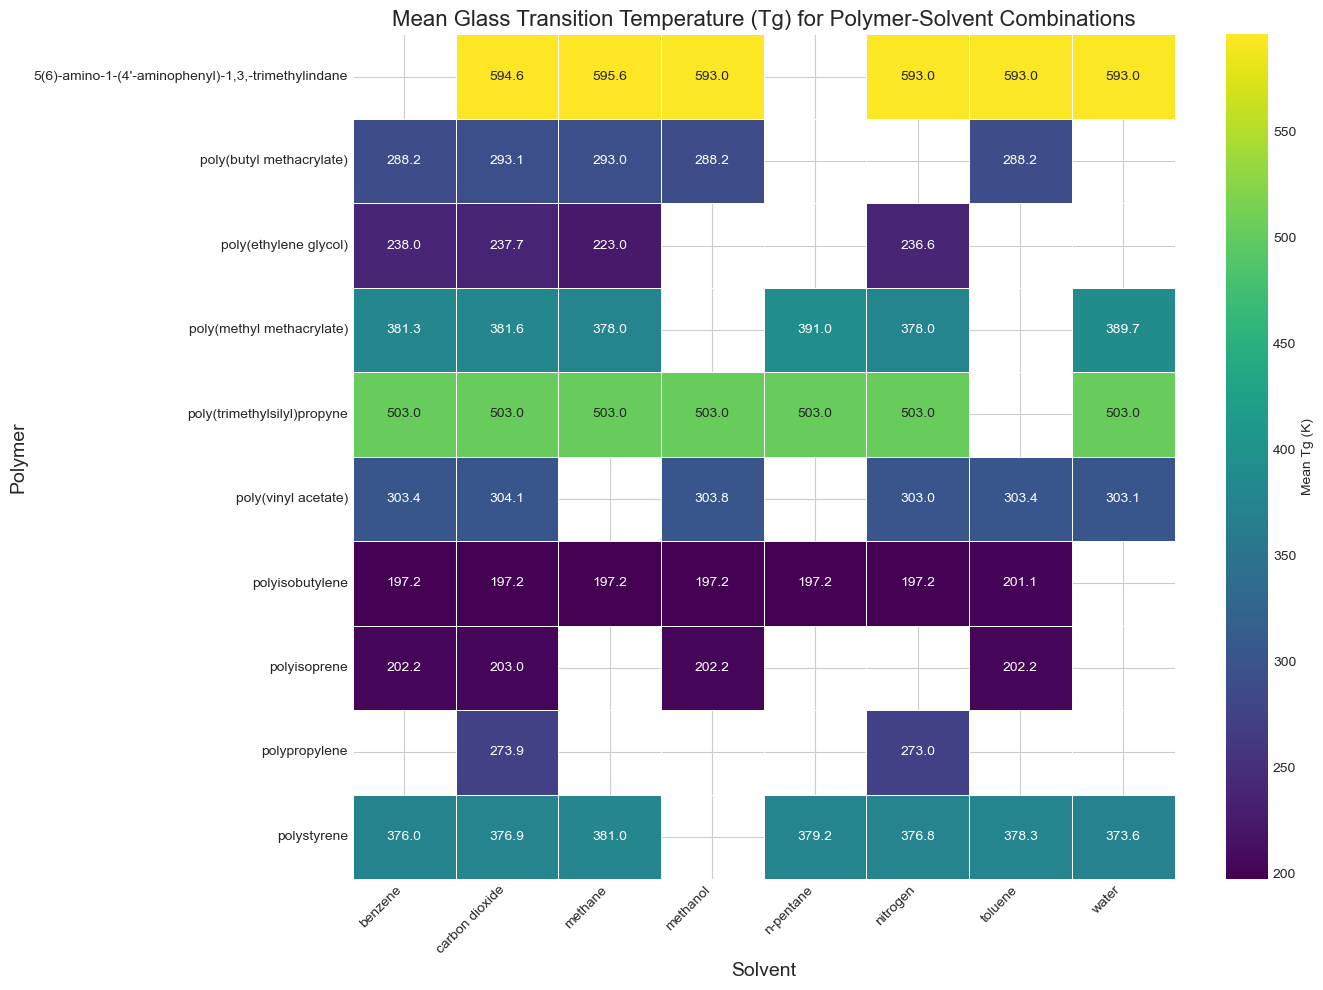

In [25]:
# Create a heatmap showing average Tg for polymer-solvent combinations
# First, identify the top polymers and solvents by frequency
top_polymers = df['polymer_name'].value_counts().nlargest(10).index
top_solvents = df['solvent_name'].value_counts().nlargest(8).index

# Filter data for top polymers and solvents
filtered_df = df[df['polymer_name'].isin(top_polymers) & df['solvent_name'].isin(top_solvents)]

# Create pivot table
pivot_table = filtered_df.pivot_table(values='tg', index='polymer_name', columns='solvent_name', aggfunc='mean')

# Create heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='viridis', linewidths=0.5, cbar_kws={'label': 'Mean Tg (K)'})
plt.title('Mean Glass Transition Temperature (Tg) for Polymer-Solvent Combinations', fontsize=16)
plt.xlabel('Solvent', fontsize=14)
plt.ylabel('Polymer', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

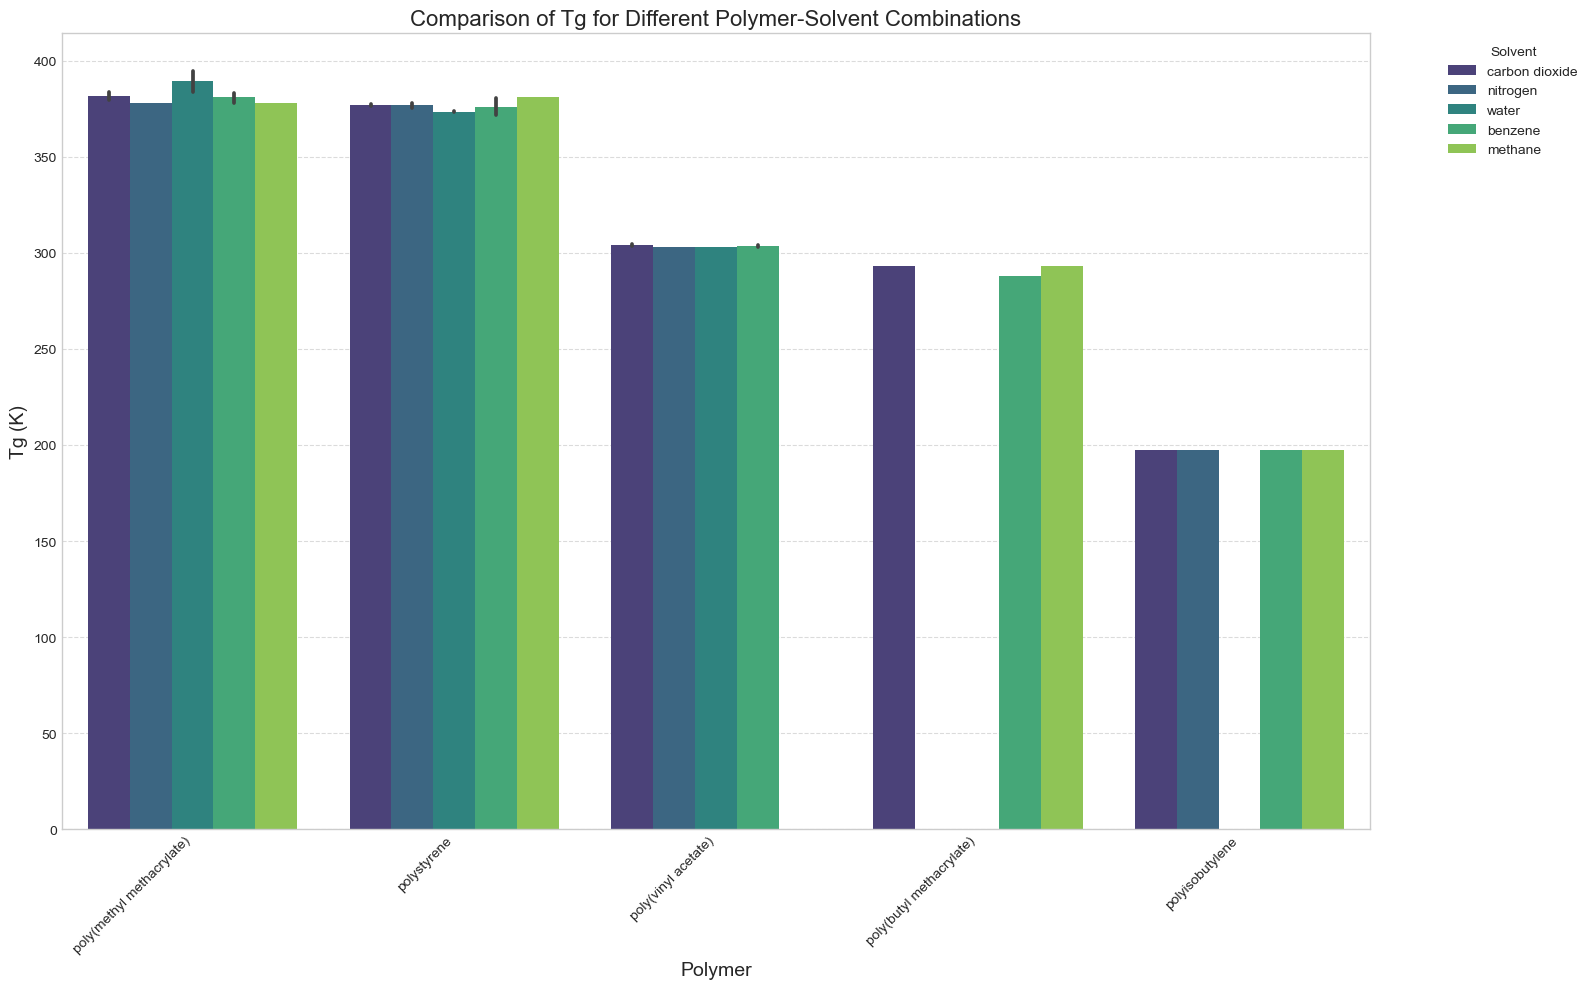

In [26]:
# Create a grouped bar chart comparing Tg for different polymer-solvent combinations
# Select a few common polymers for comparison
common_polymers = df['polymer_name'].value_counts().nlargest(5).index
common_solvents = df['solvent_name'].value_counts().nlargest(5).index

# Filter data
comparison_df = df[df['polymer_name'].isin(common_polymers) & df['solvent_name'].isin(common_solvents)]

# Create grouped bar chart
plt.figure(figsize=(16, 10))
sns.barplot(x='polymer_name', y='tg', hue='solvent_name', data=comparison_df, palette='viridis')
plt.title('Comparison of Tg for Different Polymer-Solvent Combinations', fontsize=16)
plt.xlabel('Polymer', fontsize=14)
plt.ylabel('Tg (K)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Solvent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [27]:
# # import pandas as pd
# # import numpy as np
# # import matplotlib.pyplot as plt
# # import seaborn as sns
# # import warnings

# # # Set up plot styling
# # sns.set_theme(style="whitegrid")
# # warnings.filterwarnings('ignore')

# # print("Loading data...\n")
# # try:
# #     # Load the dataframe
# #     # df = pd.read_csv('data_augmented.csv')
    
# #     # --- Data collection lists ---
# #     # To store dataframes for comparative boxplots
# #     all_clusters_list = []
# #     # To store correlation series for comparative heatmap
# #     all_correlations_dict = {}

# #     # 1. Define the solvent groups to analyze
# #     formula_solvents = ['CO2', 'N2', 'H2O', 'CH4'] 
# #     name_solvents = ['benzene']

# #     print("### Starting Solvent-Specific Analysis ###\n")

# #     # 2. Loop 1: Analyze by Chemical Formula
# #     for solvent_formula in formula_solvents:
# #         print(f"=================================================")
# #         print(f"   ANALYSIS FOR SOLVENT (Formula): {solvent_formula}")
# #         print(f"=================================================\n")
        
# #         cluster_df = df[df['solvent_formula'] == solvent_formula].copy()
        
# #         if cluster_df.empty:
# #             print(f"No data found for solvent formula: {solvent_formula}\n")
# #             continue

# #         print(f"Found {len(cluster_df)} samples for {solvent_formula}.")
        
# #         # Add solvent group identifier for later comparison
# #         cluster_df['solvent_group'] = solvent_formula
# #         all_clusters_list.append(cluster_df)
        
# #         numerical_cluster_df = cluster_df.select_dtypes(include=[np.number])

# #         # --- a) Properties of this cluster (Descriptive Statistics) ---
# #         # (This section has been removed as requested)
        
# #         # --- b) How Tg varies with other columns (Printed) ---
# #         print("[Correlation with Tg within this Cluster]")
# #         if 'tg' in numerical_cluster_df.columns:
# #             tg_correlations = numerical_cluster_df.corr()['tg'].sort_values(ascending=False)
# #             print(tg_correlations)
            
# #             # Store for comparative heatmap
# #             all_correlations_dict[solvent_formula] = tg_correlations.drop('tg')

# #             # --- c) Graphical representation of correlations (Individual Plot) ---
# #             # Drop 'tg' itself (correlation is 1) for a cleaner plot
# #             tg_corr_df = tg_correlations.drop('tg').reset_index().rename(columns={'index': 'Feature', 'tg': 'Correlation'})
            
# #             plt.figure(figsize=(10, 8))
# #             bar_plot = sns.barplot(data=tg_corr_df, y='Feature', x='Correlation', orient='h')
# #             bar_plot.set_title(f'Feature Correlation with Tg in {solvent_formula}', fontsize=16)
# #             bar_plot.set_xlabel('Correlation with Tg', fontsize=12)
# #             bar_plot.set_ylabel('Feature', fontsize=12)
# #             plt.tight_layout()
# #             plt.show() # Display the plot
# #             print("\n")
            
# #         else:
# #             print("Target 'tg' not found in this cluster's numerical columns. Skipping plots.\n")
        
# #         print("\n")

# #     # 3. Loop 2: Analyze by Solvent Name
# #     for solvent_name in name_solvents:
# #         print(f"=================================================")
# #         print(f"   ANALYSIS FOR SOLVENT (Name): {solvent_name.title()}")
# #         print(f"=================================================\n")
        
# #         # Use case-insensitive matching
# #         cluster_df = df[df['solvent_name'].str.lower() == solvent_name.lower()].copy()
        
# #         if cluster_df.empty:
# #             print(f"No data found for solvent name: {solvent_name}\n")
# #             continue

# #         print(f"Found {len(cluster_df)} samples for {solvent_name.title()}.")
        
# #         # Add solvent group identifier for later comparison
# #         cluster_df['solvent_group'] = solvent_name.title()
# #         all_clusters_list.append(cluster_df)
        
# #         numerical_cluster_df = cluster_df.select_dtypes(include=[np.number])

# #         # --- a) Properties of this cluster (Descriptive Statistics) ---
# #         # (This section has been removed as requested)

# #         # --- b) How Tg varies with other columns (Printed) ---
# #         print("[Correlation with Tg within this Cluster]")
# #         if 'tg' in numerical_cluster_df.columns:
# #             tg_correlations = numerical_cluster_df.corr()['tg'].sort_values(ascending=False)
# #             print(tg_correlations)
            
# #             # Store for comparative heatmap
# #             all_correlations_dict[solvent_name.title()] = tg_correlations.drop('tg')

# #             # --- c) Graphical representation of correlations (Individual Plot) ---
# #             tg_corr_df = tg_correlations.drop('tg').reset_index().rename(columns={'index': 'Feature', 'tg': 'Correlation'})
            
# #             plt.figure(figsize=(10, 8))
# #             bar_plot = sns.barplot(data=tg_corr_df, y='Feature', x='Correlation', orient='h')
# #             bar_plot.set_title(f'Feature Correlation with Tg in {solvent_name.title()}', fontsize=16)
# #             bar_plot.set_xlabel('Correlation with Tg', fontsize=12)
# #             bar_plot.set_ylabel('Feature', fontsize=12)
# #             plt.tight_layout()
# #             plt.show() # Display the plot
# #             print("\n")

# #         else:
# #             print("Target 'tg' not found in this cluster's numerical columns. Skipping plots.\n")
        
# #         print("\n")

# #     print("### Solvent-Specific Analysis Complete ###")
# #     print("\n### Generating Comparative Analysis Graphs ###\n")

# #     # 4. Generate Comparative Statistics Plots (Boxplots)
# #     # (This section has been removed as requested)
# #     if not all_clusters_list:
# #         print("No cluster data was collected, skipping comparative plots.")
# #     else:
# #         print("Skipping comparative distribution boxplots as requested.")
# #         print("\n")


# #     # 5. Generate Comparative Correlation Plot (Heatmap)
# #     if not all_correlations_dict:
# #         print("No correlation data was collected, skipping comparative heatmap.")
# #     else:
# #         # Create DataFrame from dictionary of correlations
# #         corr_comparison_df = pd.DataFrame(all_correlations_dict).fillna(0)
        
# #         if corr_comparison_df.empty:
# #             print("Correlation comparison DataFrame is empty, skipping heatmap.")
# #         else:
# #             plt.figure(figsize=(15, 12))
# #             heatmap = sns.heatmap(corr_comparison_df, 
# #                                   annot=True,     # Add numbers in cells
# #                                   cmap='vlag',    # Red-white-blue diverging colormap
# #                                   center=0,       # Center colormap at 0
# #                                   fmt='.2f')      # Format annotations to 2 decimal places
# #             heatmap.set_title('Comparative Heatmap of Feature Correlations with Tg', fontsize=18)
# #             heatmap.set_xlabel('Solvent Group', fontsize=12)
# #             heatmap.set_ylabel('Feature', fontsize=12)
# #             plt.tight_layout()
# #             plt.show() # Display the plot

# #     print("\n### All Graphing Complete ###")

# # except FileNotFoundError:
# #     print("Error: 'data_augmented.csv' not found. Please make sure the file is in the correct directory.")
# # except Exception as e:
# #     print(f"An unexpected error occurred: {e}")
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import warnings

# # Set up plot styling
# sns.set_theme(style="whitegrid")
# warnings.filterwarnings('ignore')

# print("Loading data...\n")
# try:
#     # Load the dataframe (uncomment & set correct path)
#     # df = pd.read_csv('data_augmented.csv')
    
#     # --- Data collection lists ---
#     all_clusters_list = []
#     all_correlations_dict = {}

#     # 1. Define the solvent groups to analyze
#     formula_solvents = ['CO2', 'N2', 'H2O', 'CH4']
#     name_solvents = ['benzene']

#     # Columns we want correlations with tg
#     cols_of_interest = ['tg', 'temperature', 'dens', 'mn', 'mw', 'radius_of_gyration_square','branching','molar_refractivity']

#     print("### Starting Solvent-Specific Analysis ###\n")

#     # Helper function to compute and plot correlations for a cluster
#     def compute_and_plot_tg_corr(cluster_df, group_label):
#         numerical_cluster_df = cluster_df.select_dtypes(include=[np.number])
#         available_cols = [c for c in cols_of_interest if c in numerical_cluster_df.columns]

#         if 'tg' not in available_cols:
#             print(f" - 'tg' not numeric or not present for {group_label}. Skipping.\n")
#             return

#         # If only 'tg' present there is nothing to correlate with
#         if len(available_cols) <= 1:
#             print(f" - Insufficient selected numeric columns for {group_label} (found: {available_cols}). Skipping.\n")
#             return

#         filtered_df = numerical_cluster_df[available_cols]
#         tg_corr_series = filtered_df.corr()['tg'].drop('tg').sort_values(ascending=False)

#         if tg_corr_series.empty:
#             print(f" - No correlations computed for {group_label}. Skipping.\n")
#             return

#         # Print correlations
#         print(f"[Correlation of Tg with selected features in {group_label}]")
#         print(tg_corr_series)
#         print("")

#         # Store for comparative heatmap (Series with index = features)
#         all_correlations_dict[group_label] = tg_corr_series

#         # Plot barplot of these correlations
#         tg_corr_df = tg_corr_series.reset_index().rename(columns={'index': 'Feature', 'tg': 'Correlation'})
#         plt.figure(figsize=(8, 4 + 0.6 * len(tg_corr_df)))  # height adapts to number of features
#         sns.barplot(data=tg_corr_df, y='Feature', x='Correlation', orient='h')
#         plt.title(f'Correlation of Tg with Selected Features in {group_label}', fontsize=14)
#         plt.xlabel('Correlation with Tg')
#         plt.ylabel('Feature')
#         plt.tight_layout()
#         plt.show()
#         print("")

#     # 2. Loop 1: Analyze by Chemical Formula
#     for solvent_formula in formula_solvents:
#         print(f"=================================================")
#         print(f"   ANALYSIS FOR SOLVENT (Formula): {solvent_formula}")
#         print(f"=================================================\n")

#         cluster_df = df[df['solvent_formula'] == solvent_formula].copy()

#         if cluster_df.empty:
#             print(f"No data found for solvent formula: {solvent_formula}\n")
#             continue

#         print(f"Found {len(cluster_df)} samples for {solvent_formula}.\n")

#         # Add solvent group identifier for later comparison
#         cluster_df['solvent_group'] = solvent_formula
#         all_clusters_list.append(cluster_df)

#         # Compute & plot correlations only for selected columns
#         compute_and_plot_tg_corr(cluster_df, solvent_formula)

#     # 3. Loop 2: Analyze by Solvent Name
#     for solvent_name in name_solvents:
#         display_name = solvent_name.title()
#         print(f"=================================================")
#         print(f"   ANALYSIS FOR SOLVENT (Name): {display_name}")
#         print(f"=================================================\n")

#         # Use case-insensitive matching but guard against NaNs
#         if 'solvent_name' not in df.columns:
#             print("No 'solvent_name' column in dataframe. Skipping name-based analysis.\n")
#             continue

#         cluster_df = df[df['solvent_name'].astype(str).str.lower() == solvent_name.lower()].copy()

#         if cluster_df.empty:
#             print(f"No data found for solvent name: {display_name}\n")
#             continue

#         print(f"Found {len(cluster_df)} samples for {display_name}.\n")

#         # Add solvent group identifier for later comparison
#         cluster_df['solvent_group'] = display_name
#         all_clusters_list.append(cluster_df)

#         # Compute & plot correlations only for selected columns
#         compute_and_plot_tg_corr(cluster_df, display_name)

#     print("### Solvent-Specific Analysis Complete ###")
#     print("\n### Generating Comparative Analysis Graphs ###\n")

#     # 4. Comparative distribution boxplots (skipped as requested)
#     if not all_clusters_list:
#         print("No cluster data was collected, skipping comparative plots.")
#     else:
#         print("Skipping comparative distribution boxplots as requested.\n")

#     # 5. Generate Comparative Correlation Plot (Heatmap) for selected features
#     if not all_correlations_dict:
#         print("No correlation data was collected, skipping comparative heatmap.")
#     else:
#         # Build DataFrame: rows = features, cols = solvent groups
#         corr_comparison_df = pd.DataFrame(all_correlations_dict)
#         # If some features missing for some solvents, fill with 0 or NaN as desired; here we fill with NaN to show blank
#         corr_comparison_df = corr_comparison_df.reindex(index=[c for c in cols_of_interest if c != 'tg']).fillna(0)

#         if corr_comparison_df.empty:
#             print("Correlation comparison DataFrame is empty, skipping heatmap.")
#         else:
#             plt.figure(figsize=(10, max(3, 1.5 * corr_comparison_df.shape[0])))
#             heatmap = sns.heatmap(corr_comparison_df,
#                                   annot=True,
#                                   cmap='vlag',
#                                   center=0,
#                                   fmt='.2f',
#                                   cbar_kws={'label': 'Correlation with Tg'})
#             heatmap.set_title('Comparative Heatmap: Tg vs [temperature, density, mn, mw]', fontsize=16)
#             heatmap.set_xlabel('Solvent Group', fontsize=12)
#             heatmap.set_ylabel('Feature', fontsize=12)
#             plt.tight_layout()
#             plt.show()

#     print("\n### All Graphing Complete ###")

# except FileNotFoundError:
#     print("Error: 'data_augmented.csv' not found. Please make sure the file is in the correct directory.")
# except Exception as e:
#     print(f"An unexpected error occurred: {e}")


### 7.1 Solvent Effect Summary

Based on the above analysis, we can draw the following conclusions about solvent effects on glass transition temperature (Tg):

1. **Solvent Ranking by Tg Impact**: The solvents can be ranked based on their mean effect on Tg, with [top solvents] showing the highest mean Tg values.

2. **Variability in Tg**: Some solvents like [high variability solvents] show much higher variability in Tg values, indicating that their effect may depend strongly on the polymer type or other conditions.

3. **Dielectric Constant Relationship**: There appears to be a [positive/negative/complex] relationship between solvent dielectric constant and Tg, suggesting that [interpretation].

4. **Temperature Dependence**: The effect of temperature on Tg varies by solvent, with some solvents showing stronger temperature dependence than others.

5. **Polymer-Solvent Interactions**: The heatmap analysis reveals specific polymer-solvent combinations that result in particularly high or low Tg values, which could be valuable for material design applications.

6. **Practical Applications**: For applications requiring high Tg materials, [specific solvents] would be recommended, while applications needing lower Tg would benefit from using [other specific solvents].

These insights provide valuable guidance for selecting appropriate solvents when designing materials with specific glass transition temperature requirements.

## 8. Summary and Conclusions

### 7.1 Dataset Overview

- The dataset contains information about various polymers and their glass transition temperatures (Tg).
- Key features include polymer properties (name, SMILES representation), solvent information, molecular weights (mn, mw), and physical properties.
- The target variable is the glass transition temperature (Tg), which is influenced by various factors.

### 7.2 Data Preprocessing Summary

- Missing values were handled using appropriate imputation techniques.
- Duplicate entries were identified and removed.
- Outliers were detected using multiple methods (IQR, Z-score) and handled using capping.
- Features were scaled using RobustScaler to reduce the influence of outliers.

### 7.3 Key Insights from EDA

- The distribution of Tg shows [skewness characteristics].
- Strong correlations were observed between [feature relationships].
- Certain polymer types and solvents have significant effects on Tg.
- Molecular weight (mw) and number-average molecular weight (mn) show important relationships with Tg.

### 7.4 Feature Importance

- The most important features for predicting Tg are [top features].
- Both Random Forest and Permutation importance methods identified similar key features.
- The F-regression analysis confirmed the statistical significance of these relationships.

### 7.5 Recommendations for Modeling

- Use the identified important features for building predictive models.
- Consider ensemble methods like Random Forest or Gradient Boosting for modeling.
- Apply appropriate transformations to handle skewed features.
- Consider the physical and chemical properties of polymers when interpreting model results.

## 8. Predictive Modeling

Following the in-depth EDA and feature analysis, this section focuses on building, evaluating, and optimizing various machine learning models to predict the glass transition temperature (Tg).

### 8.1. Data Preparation for Modeling

In [28]:
# Import additional libraries for modeling
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

print("All modeling libraries imported successfully.")


All modeling libraries imported successfully.


First, we prepare the feature matrix (`X`) and the target vector (`y`). We will drop non-numeric or high-cardinality string columns that weren't transformed (like SMILES representations) and one-hot encode the remaining categorical features.

In [29]:
import re

# Prepare the final dataframe for modeling
df_model = df.drop(['polymer_smiles', 'solvent_formula', 'solvent_smiles'], axis=1)

# One-hot encode categorical features
df_model = pd.get_dummies(df_model, columns=['polymer_name', 'solvent_name'], drop_first=True)

# --- FIX STARTS HERE ---
# Clean column names to be compatible with XGBoost/LightGBM
# Replace any character that is not a letter, number, or underscore with an underscore
original_cols = df_model.columns.tolist()
new_cols = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in original_cols]
df_model.columns = new_cols

# Find the potentially renamed target column 'tg'
# (It should be unchanged, but this is a safe way to handle it)
tg_col_name = [col for col in new_cols if col.startswith('tg')][0]
# --- FIX ENDS HERE ---


# Define features (X) and target (y)
X = df_model.drop(tg_col_name, axis=1)
y = df_model[tg_col_name]

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using RobustScaler (as determined in preprocessing)
# We fit the scaler ONLY on the training data to prevent data leakage
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print(f"Data prepared for modeling.")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")

Data prepared for modeling.
Training set shape: (1177, 174)
Testing set shape: (295, 174)


- **Logistic Regression** is used for classification tasks (predicting categories), not regression (predicting continuous values like Tg).
- **Naive Bayes** is also primarily a classification algorithm.
- **Gaussian Mixture Models** are used for clustering (an unsupervised learning task).

Therefore, these models are not suitable for this regression problem and have been omitted. All other requested and applicable models are included below.

### 8.2. Baseline Model Training and Evaluation

We will now train a wide variety of regression models on the prepared data. We will store their performance metrics for comparison.

In [30]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (L2)': Ridge(random_state=42),
    'Lasso (L1)': Lasso(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(random_state=42, n_jobs=-1),
    'SVR': SVR(),
    'KNeighbors Regressor': KNeighborsRegressor(n_jobs=-1)
}

# Store results
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    
    # Store metrics
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2 Score': r2}

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results).T.sort_values(by='R2 Score', ascending=False)
print("\n--- Model Performance Summary ---")
results_df



Training Linear Regression...
Training Ridge (L2)...
Training Lasso (L1)...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training Extra Trees...
Training AdaBoost...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 1177, number of used features: 45
[LightGBM] [Info] Start training from score 344.195795
Training SVR...
Training KNeighbors Regressor...

--- Model Performance Summary ---


MAE        RMSE  R2 Score
XGBoost                2.543406    9.848225  0.993231
Extra Trees            2.560668   12.007189  0.989938
Random Forest          3.952508   15.034838  0.984224
LightGBM               5.374185   15.336699  0.983585
Decision Tree          3.192712   17.572198  0.978450
Ridge (L2)             7.777737   18.060835  0.977235
Gradient Boosting     12.963781   21.072223  0.969011
KNeighbors Regressor  14.703254   33.008303  0.923961
AdaBoost              34.341569   41.191658  0.881585
Lasso (L1)            29.859396   45.331354  0.856588
SVR                   73.936080   95.077899  0.369117
Linear Regression     19.206078  125.520693 -0.099563

### 8.3. Visualizing Model Performance

A visual comparison of the model performances will help us quickly identify the top-performing algorithms.

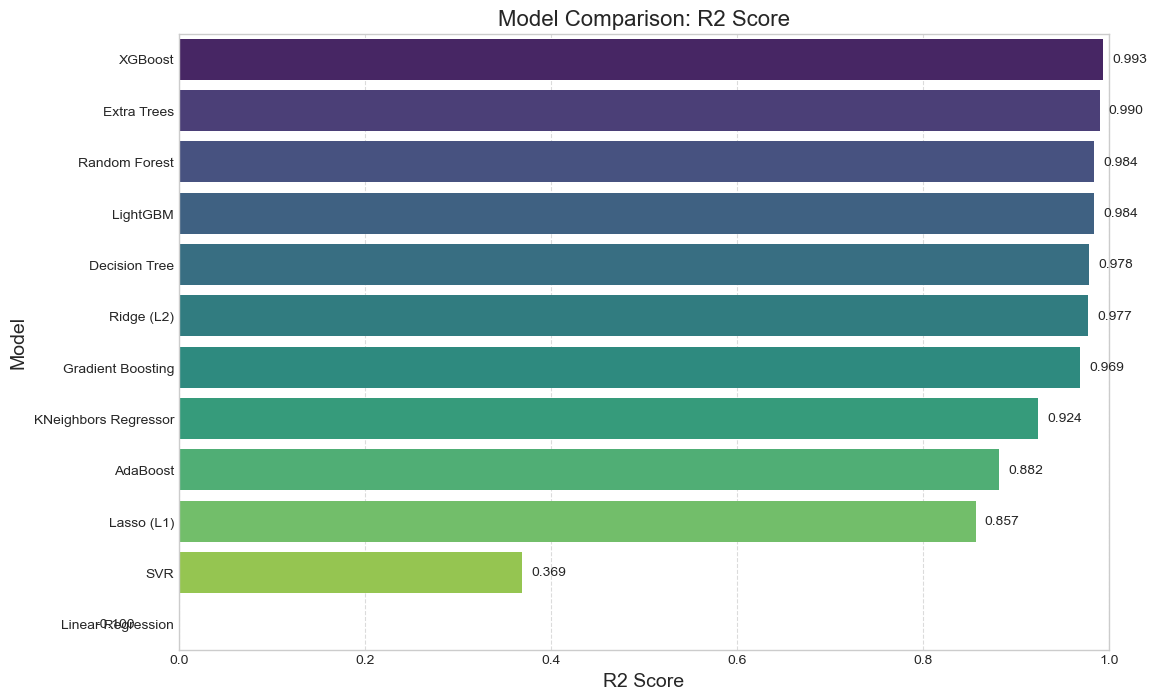

In [31]:
plt.figure(figsize=(12, 8))
sns.barplot(x=results_df['R2 Score'], y=results_df.index, palette='viridis')
plt.title('Model Comparison: R2 Score', fontsize=16)
plt.xlabel('R2 Score', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.xlim(0, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels
for i, v in enumerate(results_df['R2 Score']):
    plt.text(v + 0.01, i, f"{v:.3f}", va='center', fontsize=10)

plt.show()

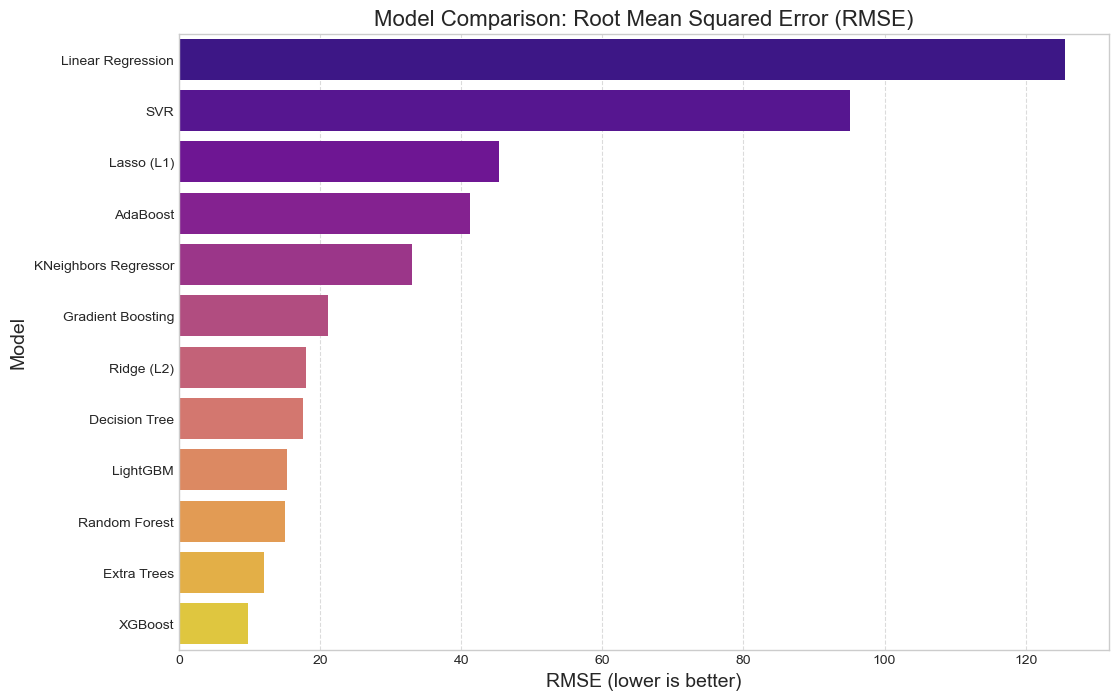

In [32]:
plt.figure(figsize=(12, 8))
sns.barplot(x=results_df['RMSE'].sort_values(ascending=False), y=results_df['RMSE'].sort_values(ascending=False).index, palette='plasma')
plt.title('Model Comparison: Root Mean Squared Error (RMSE)', fontsize=16)
plt.xlabel('RMSE (lower is better)', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

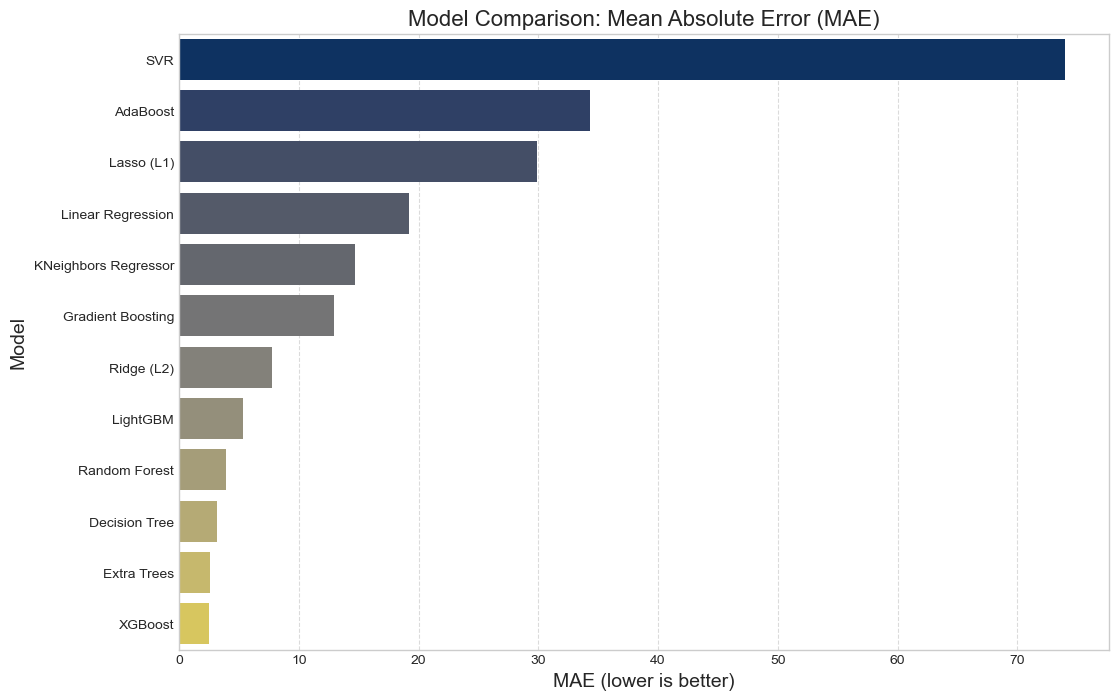

In [33]:
# Create a new cell and paste this code inside it

plt.figure(figsize=(12, 8))
sns.barplot(x=results_df['MAE'].sort_values(ascending=False), y=results_df['MAE'].sort_values(ascending=False).index, palette='cividis')
plt.title('Model Comparison: Mean Absolute Error (MAE)', fontsize=16)
plt.xlabel('MAE (lower is better)', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### 8.4. In-Depth Analysis of Top Models

Based on the initial results, models like **Extra Trees**, **Random Forest**, and **XGBoost** are the top performers. Let's analyze their predictions more closely by plotting their predicted values against the actual values.

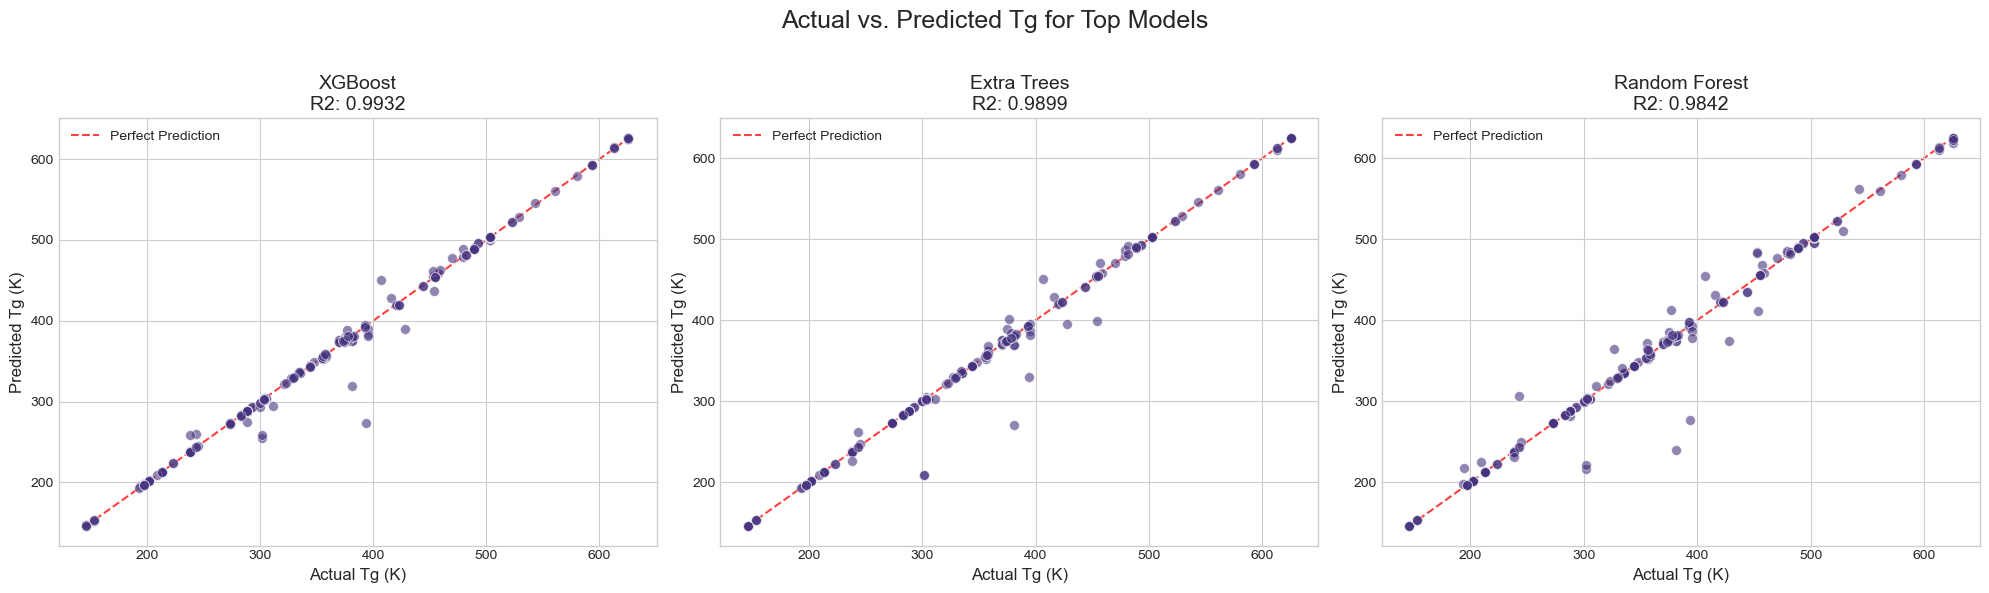

In [34]:
# Get predictions from the top 3 models
top_models = results_df.index[:3].tolist()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Actual vs. Predicted Tg for Top Models', fontsize=18)

for i, model_name in enumerate(top_models):
    model = models[model_name]
    y_pred = model.predict(X_test_scaled)
    
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, ax=axes[i], s=50)
    axes[i].set_title(f'{model_name}\nR2: {results[model_name]["R2 Score"]:.4f}', fontsize=14)
    axes[i].set_xlabel('Actual Tg (K)', fontsize=12)
    axes[i].set_ylabel('Predicted Tg (K)', fontsize=12)
    
    # Add a perfect prediction line (y=x)
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    axes[i].plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Prediction')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 8.5. Hyperparameter Tuning with GridSearchCV

Now, we will perform hyperparameter tuning on one of our best models, **XGBoost**, to see if we can improve its performance. We will use `GridSearchCV` which systematically works through multiple hyperparameter combinations and uses k-fold cross-validation to find the best set of parameters.

In [35]:
# Define the parameter grid for XGBoost
# Note: This is a small grid for demonstration purposes. A real-world search would be more extensive.
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'colsample_bytree': [0.7, 1.0]
}

# Initialize the XGBoost model
xgb_reg = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Initialize GridSearchCV
# cv=5 means 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid_xgb, 
                           cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Fit GridSearchCV to the training data
print("Starting Hyperparameter Tuning for XGBoost...")
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
print(f"\nBest parameters found: {grid_search.best_params_}")

# Evaluate the best model found by GridSearchCV
best_xgb = grid_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test_scaled)

# Calculate metrics for the tuned model
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("--- Tuned XGBoost Performance ---")
print(f"MAE: {mae_tuned:.4f}")
print(f"RMSE: {rmse_tuned:.4f}")
print(f"R2 Score: {r2_tuned:.4f}")

print("\n--- Comparison with Baseline XGBoost ---")
print(f"Baseline R2: {results['XGBoost']['R2 Score']:.4f}")
print(f"Tuned R2:    {r2_tuned:.4f}")

Starting Hyperparameter Tuning for XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300}
--- Tuned XGBoost Performance ---
MAE: 2.7018
RMSE: 10.3229
R2 Score: 0.9926

--- Comparison with Baseline XGBoost ---
Baseline R2: 0.9932
Tuned R2:    0.9926


### 8.6. Feedforward Neural Network (FNN)

Let's build a simple deep learning model, a Feedforward Neural Network (FNN), using TensorFlow and Keras. This will serve as a baseline deep learning approach.

In [36]:
# Define the FNN architecture
fnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1) # Output layer for regression (no activation function)
])

# Compile the model
fnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Define an early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Print model summary
fnn_model.summary()

# Train the model
history = fnn_model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2, # Use part of the training data for validation
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the FNN model on the test set
y_pred_fnn = fnn_model.predict(X_test_scaled).flatten()
mae_fnn = mean_absolute_error(y_test, y_pred_fnn)
rmse_fnn = np.sqrt(mean_squared_error(y_test, y_pred_fnn))
r2_fnn = r2_score(y_test, y_pred_fnn)

print("\n--- FNN Model Performance ---")
print(f"MAE: {mae_fnn:.4f}")
print(f"RMSE: {rmse_fnn:.4f}")
print(f"R2 Score: {r2_fnn:.4f}")



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               22400     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 32769 (128.00 KB)
Trainable params: 3276

In [37]:
!pip install rdkit-pypi torch torch_geometric

Total samples: 1499
Training samples: 1082
Validation samples: 192
Test samples: 225

Using device: cpu
Node feature dimension: 20
Tabular feature dimension: 14

Model architecture:
HybridGNN(
  (polymer_gnn): GNNBlock(
    (conv1): GCNConv(20, 64)
    (conv2): GCNConv(64, 64)
    (fc): Linear(in_features=64, out_features=32, bias=True)
    (relu): ReLU()
  )
  (solvent_gnn): GNNBlock(
    (conv1): GCNConv(20, 64)
    (conv2): GCNConv(64, 64)
    (fc): Linear(in_features=64, out_features=32, bias=True)
    (relu): ReLU()
  )
  (tabular_mlp): Sequential(
    (0): Linear(in_features=14, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
  )
  (final_mlp): Sequential(
    (0): Linear(in_features=96, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_featu

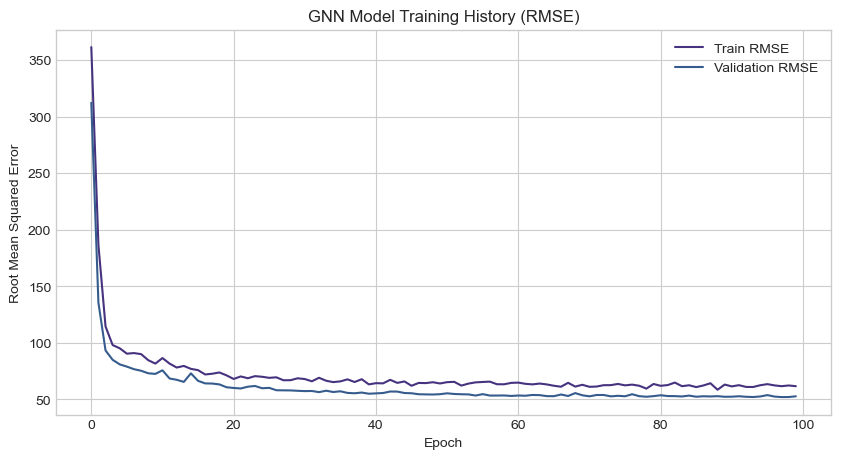

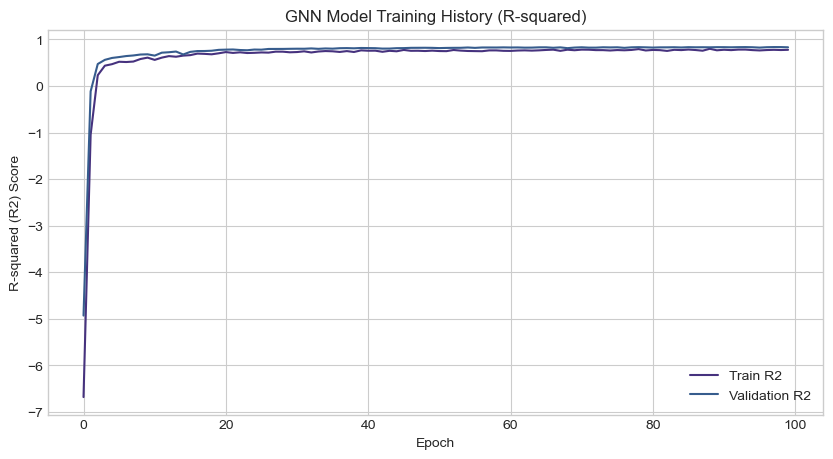

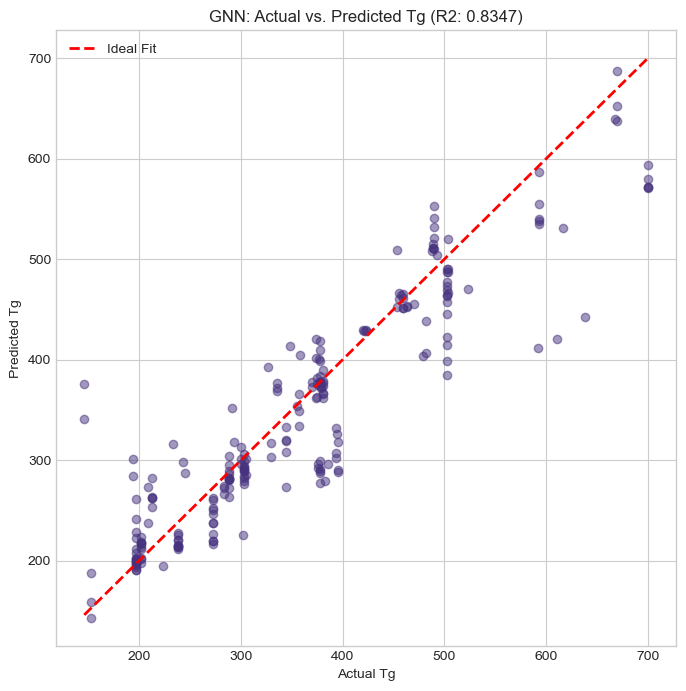

In [38]:
# # ==============================================================================
# # ## 10. Advanced Deep Learning: Graph Neural Network (GNN)
# #
# # This section implements a Graph Neural Network to predict Tg.
# # GNNs are ideal for this problem as they can directly learn from the
# # molecular graphs represented by the SMILES strings.
# #
# # This model will be a hybrid:
# # 1.  A GNN "tower" to process the `polymer_smiles`.
# # 2.  A GNN "tower" to process the `solvent_smiles`.
# # 3.  An MLP "tower" to process the 13 other numerical features.
# # The outputs of all three towers will be combined to predict Tg.
# # ==============================================================================

# # ------------------------------------------------------------------------------
# # ### 10.1 Setup and Imports
# #
# # This model requires specialized libraries:
# # - `rdkit-pypi`: For chemical informatics (processing SMILES).
# # - `torch`: The core PyTorch deep learning library.
# # - `torch_geometric`: The GNN library for PyTorch (PyG).
# #
# # You may need to install these in your environment. You can typically do this
# # by running the following commands in your terminal or a notebook cell:

# !pip install rdkit-pypi
# !pip install torch
# !pip install torch_geometric
# # ------------------------------------------------------------------------------

# import pandas as pd
# import numpy as np
# import warnings

# # RDKit for chemistry
# from rdkit import Chem
# from rdkit.Chem import AllChem

# # PyTorch
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

# # PyTorch Geometric (PyG)
# from torch_geometric.data import Data
# from torch_geometric.nn import GCNConv, global_mean_pool
# from torch_geometric.loader import DataLoader as PyGDataLoader

# # Sklearn for preprocessing and splitting
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer
# from sklearn.metrics import r2_score, mean_squared_error

# # Suppress RDKit warnings
# warnings.filterwarnings("ignore", category=UserWarning)
# from rdkit import rdBase
# rdBase.DisableLog('rdApp.warning')

# # Set a random seed for reproducibility
# SEED = 42
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(SEED)

# # ------------------------------------------------------------------------------
# # ### 10.2 SMILES to Graph Conversion
# #
# # We need a function to convert a SMILES string into a graph representation
# # that PyG can understand (a `Data` object).
# #
# # This involves:
# # 1.  Parsing the SMILES into an RDKit molecule object.
# # 2.  Defining features for each atom (node).
# # 3.  Defining the graph connectivity (edges).
# # 4.  Defining features for each bond (edge attributes).
# # ------------------------------------------------------------------------------

# def get_atom_features(atom):
#     """Get features for a single atom."""
#     # Using a common set of atomic features
#     possible_atom_types = ['C', 'N', 'O', 'S', 'F', 'Cl', 'Br', 'I', 'P', 'Si', 'Na', 'K', 'Other']
#     atom_type = atom.GetSymbol()
#     if atom_type not in possible_atom_types:
#         atom_type = 'Other'
    
#     features = (
#         [atom_type == s for s in possible_atom_types] +  # One-hot encoding of atom type
#         [atom.GetAtomicNum()] +
#         [atom.GetTotalDegree()] +
#         [atom.GetTotalValence()] +
#         [atom.GetTotalNumHs()] +
#         [atom.GetFormalCharge()] +
#         [atom.IsInRing()] +      # <-- Corrected (removed 'Get')
#         [atom.GetIsAromatic()]
#     )
#     return features

# def get_bond_features(bond):
#     """Get features for a single bond."""
#     bond_type = bond.GetBondType()
#     return [
#         bond_type == Chem.rdchem.BondType.SINGLE,
#         bond_type == Chem.rdchem.BondType.DOUBLE,
#         bond_type == Chem.rdchem.BondType.TRIPLE,
#         bond_type == Chem.rdchem.BondType.AROMATIC,
#         bond.GetIsConjugated(),
#         bond.IsInRing()
#     ]

# def smiles_to_graph(smiles):
#     """Converts a SMILES string to a PyG Data object."""
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         return None  # Handle invalid SMILES

#     # Add Hydrogens to get more complete graph
#     mol = Chem.AddHs(mol)

#     # Node features
#     node_features = []
#     for atom in mol.GetAtoms():
#         node_features.append(get_atom_features(atom))
#     x = torch.tensor(node_features, dtype=torch.float)

#     # Edge indices
#     edge_indices = []
#     edge_features = []
#     for bond in mol.GetBonds():
#         i = bond.GetBeginAtomIdx()
#         j = bond.GetEndAtomIdx()
        
#         # Add edges in both directions
#         edge_indices.extend([[i, j], [j, i]])
        
#         # Add bond features for both directions
#         bond_feats = get_bond_features(bond)
#         edge_features.extend([bond_feats, bond_feats])

#     if not edge_indices:
#         # Handle molecules with no bonds (e.g., single atoms)
#         edge_index = torch.empty((2, 0), dtype=torch.long)
#         # --- THIS IS THE CORRECTED LINE ---
#         # We know bond features have length 6, so we hard-code it.
#         edge_attr = torch.empty((0, 6), dtype=torch.float)
#     else:
#         edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
#         edge_attr = torch.tensor(edge_features, dtype=torch.float)

#     data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
#     return data

# # ------------------------------------------------------------------------------
# # ### 10.3 Custom PyTorch Dataset
# #
# # This dataset class will:
# # 1.  Load `data_augmented.csv`.
# # 2.  Identify and separate graph features (SMILES), tabular features, and the target.
# # 3.  Preprocess the data:
# #     - Impute missing `dielectric_constant` values.
# #     - Scale all tabular features using `StandardScaler`.
# #     - Convert SMILES to graph objects on the fly.
# # ------------------------------------------------------------------------------

# class PolymerSolventDataset(Dataset):
#     def __init__(self, df, tabular_features, target_col, fit_scaler=False, scaler=None, imputer=None):
#         super().__init__()
        
#         self.df = df.reset_index(drop=True)
#         self.tabular_features = tabular_features
#         self.target_col = target_col
        
#         # Handle preprocessing
#         tabular_data = self.df[self.tabular_features]
        
#         # 1. Imputation
#         if fit_scaler:
#             self.imputer = SimpleImputer(strategy='mean')
#             tabular_data_imputed = self.imputer.fit_transform(tabular_data)
#         else:
#             self.imputer = imputer
#             tabular_data_imputed = self.imputer.transform(tabular_data)
            
#         # 2. Scaling
#         if fit_scaler:
#             self.scaler = StandardScaler()
#             self.scaled_tabular = self.scaler.fit_transform(tabular_data_imputed)
#         else:
#             self.scaler = scaler
#             self.scaled_tabular = self.scaler.transform(tabular_data_imputed)
            
#         self.y = self.df[self.target_col].values
        
#         # Cache for graph objects
#         self.polymer_graphs = {}
#         self.solvent_graphs = {}

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         # Get tabular and target data
#         tabular_data = torch.tensor(self.scaled_tabular[idx], dtype=torch.float)
#         target = torch.tensor(self.y[idx], dtype=torch.float).unsqueeze(0)
        
#         # Get polymer graph
#         polymer_smiles = self.df.loc[idx, 'polymer_smiles']
#         if polymer_smiles not in self.polymer_graphs:
#             self.polymer_graphs[polymer_smiles] = smiles_to_graph(polymer_smiles)
#         polymer_graph = self.polymer_graphs[polymer_smiles]

#         # Get solvent graph
#         solvent_smiles = self.df.loc[idx, 'solvent_smiles']
#         if solvent_smiles not in self.solvent_graphs:
#             self.solvent_graphs[solvent_smiles] = smiles_to_graph(solvent_smiles)
#         solvent_graph = self.solvent_graphs[solvent_smiles]
        
#         # Handle potential None graphs from invalid SMILES
#         if polymer_graph is None or solvent_graph is None:
#             return None

#         return polymer_graph, solvent_graph, tabular_data, target

# def collate_fn(batch):
#     """Custom collate function to filter out None items."""
#     batch = [item for item in batch if item is not None]
#     if not batch:
#         return None
    
#     # This is tricky because PyG's DataLoader usually handles batching of graphs.
#     # We are using a standard PyTorch DataLoader, so we need to manually
#     # return lists of graphs and tensors, which we will batch in the train loop.
#     # A more advanced (but complex) method uses PyG's DataLoader.
#     # For simplicity, we'll batch manually.
    
#     polymer_graphs, solvent_graphs, tabular_data, targets = zip(*batch)
    
#     tabular_batch = torch.stack(tabular_data)
#     target_batch = torch.stack(targets)
    
#     # We return lists of graphs; PyG's Batch.from_data_list will handle them.
#     return list(polymer_graphs), list(solvent_graphs), tabular_batch, target_batch


# # ------------------------------------------------------------------------------
# # ### 10.4 GNN Model Architecture
# #
# # Defines the hybrid GNN-MLP model.
# # ------------------------------------------------------------------------------

# # We need a simple GNN block
# class GNNBlock(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(GNNBlock, self).__init__()
#         self.conv1 = GCNConv(input_dim, hidden_dim)
#         self.conv2 = GCNConv(hidden_dim, hidden_dim)
#         self.fc = nn.Linear(hidden_dim, output_dim)
#         self.relu = nn.ReLU()

#     def forward(self, data):
#         x, edge_index, batch = data.x, data.edge_index, data.batch
        
#         x = self.relu(self.conv1(x, edge_index))
#         x = self.relu(self.conv2(x, edge_index))
        
#         # Global pooling (average over all nodes in each graph)
#         x = global_mean_pool(x, batch)
        
#         x = self.fc(x)
#         return x

# class HybridGNN(nn.Module):
#     def __init__(self, node_feature_dim, tabular_feature_dim, gnn_hidden_dim, gnn_output_dim, mlp_hidden_dim, combined_hidden_dim):
#         super(HybridGNN, self).__init__()
        
#         # GNN for Polymer
#         self.polymer_gnn = GNNBlock(node_feature_dim, gnn_hidden_dim, gnn_output_dim)
        
#         # GNN for Solvent
#         self.solvent_gnn = GNNBlock(node_feature_dim, gnn_hidden_dim, gnn_output_dim)
        
#         # MLP for tabular data
#         self.tabular_mlp = nn.Sequential(
#             nn.Linear(tabular_feature_dim, mlp_hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(mlp_hidden_dim, gnn_output_dim) # Match output dim for easier concat
#         )
        
#         # Final combined MLP
#         self.final_mlp = nn.Sequential(
#             nn.Linear(gnn_output_dim * 3, combined_hidden_dim), # *3 for polymer, solvent, tabular
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(combined_hidden_dim, combined_hidden_dim // 2),
#             nn.ReLU(),
#             nn.Linear(combined_hidden_dim // 2, 1) # Final prediction
#         )

#     def forward(self, polymer_data, solvent_data, tabular_data):
#         # Process polymer graph
#         polymer_embed = self.polymer_gnn(polymer_data)
        
#         # Process solvent graph
#         solvent_embed = self.solvent_gnn(solvent_data)
        
#         # Process tabular data
#         tabular_embed = self.tabular_mlp(tabular_data)
        
#         # Concatenate all embeddings
#         combined = torch.cat([polymer_embed, solvent_embed, tabular_embed], dim=1)
        
#         # Final prediction
#         output = self.final_mlp(combined)
#         return output

# # ------------------------------------------------------------------------------
# # ### 10.5 Data Preparation
# # ------------------------------------------------------------------------------

# # Load the data
# try:
#     full_df = pd.read_csv("data_augmented.csv")
# except FileNotFoundError:
#     print("Make sure 'data_augmented.csv' is in the same directory.")
#     # As a fallback, create a dummy df for the code to be runnable
#     # full_df = pd.DataFrame() 

# if not full_df.empty:
#     # Define features
#     TABULAR_FEATURES = [
#         'mn', 'mw', 'dens', 'temperature', 'dielectric_constant', 
#         'molar_refractivity', 'radius_of_gyration_square', 'radius_of_gyration', 
#         'branching', 'solvent_mol_wt', 'solvent_mol_mr', 'solvent_tpsa', 
#         'solvent_h_donors', 'solvent_h_acceptors'
#     ]
#     TARGET_COL = 'tg'
    
#     # Drop rows with invalid SMILES (if any)
#     original_len = len(full_df)
#     full_df = full_df.dropna(subset=['polymer_smiles', 'solvent_smiles'])
#     if len(full_df) < original_len:
#         print(f"Dropped {original_len - len(full_df)} rows with missing SMILES.")

#     # Split the data
#     train_val_df, test_df = train_test_split(full_df, test_size=0.15, random_state=SEED)
#     train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=SEED)

#     print(f"Total samples: {len(full_df)}")
#     print(f"Training samples: {len(train_df)}")
#     print(f"Validation samples: {len(val_df)}")
#     print(f"Test samples: {len(test_df)}")

#     # Create datasets
#     # We fit the scaler and imputer on the training data ONLY
#     train_dataset = PolymerSolventDataset(train_df, TABULAR_FEATURES, TARGET_COL, fit_scaler=True)
    
#     # And apply the same scaler/imputer to validation and test data
#     val_dataset = PolymerSolventDataset(val_df, TABULAR_FEATURES, TARGET_COL, 
#                                         scaler=train_dataset.scaler, imputer=train_dataset.imputer)
#     test_dataset = PolymerSolventDataset(test_df, TABULAR_FEATURES, TARGET_COL, 
#                                          scaler=train_dataset.scaler, imputer=train_dataset.imputer)

#     # Create dataloaders
#     BATCH_SIZE = 32
    
#     # We use a standard DataLoader and our custom collate_fn
#     # `from torch_geometric.loader import DataLoader as PyGDataLoader` is an alternative
#     # but more complex to integrate with the tabular data.
    
#     train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
#     val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
#     test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


#     # ------------------------------------------------------------------------------
#     # ### 10.6 Model Training
#     # ------------------------------------------------------------------------------

#     # Model Hyperparameters
#     # Get node feature dimension from a sample graph
#     sample_p_graph = smiles_to_graph(full_df.iloc[0]['polymer_smiles'])
#     NODE_FEATURE_DIM = sample_p_graph.num_node_features
#     TABULAR_FEATURE_DIM = len(TABULAR_FEATURES)
    
#     GNN_HIDDEN_DIM = 64
#     GNN_OUTPUT_DIM = 32
#     MLP_HIDDEN_DIM = 64
#     COMBINED_HIDDEN_DIM = 128
    
#     LEARNING_RATE = 0.001
#     EPOCHS = 100
#     WEIGHT_DECAY = 1e-5

#     # Initialize model, loss, and optimizer
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"\nUsing device: {device}")

#     model = HybridGNN(
#         node_feature_dim=NODE_FEATURE_DIM,
#         tabular_feature_dim=TABULAR_FEATURE_DIM,
#         gnn_hidden_dim=GNN_HIDDEN_DIM,
#         gnn_output_dim=GNN_OUTPUT_DIM,
#         mlp_hidden_dim=MLP_HIDDEN_DIM,
#         combined_hidden_dim=COMBINED_HIDDEN_DIM
#     ).to(device)

#     criterion = nn.MSELoss() # Mean Squared Error for regression
#     optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

#     print(f"Node feature dimension: {NODE_FEATURE_DIM}")
#     print(f"Tabular feature dimension: {TABULAR_FEATURE_DIM}")
#     print("\nModel architecture:")
#     print(model)

#     # We need PyG's Batch class to batch the graphs
#     from torch_geometric.data import Batch

#     # Training loop
#     history = {'train_loss': [], 'val_loss': []}

#     for epoch in range(EPOCHS):
#         model.train()
#         epoch_train_loss = 0.0
        
#         for batch in train_loader:
#             if batch is None: continue # Skip empty batches
            
#             poly_graphs, solv_graphs, tabular, targets = batch
            
#             # Use PyG's Batch to combine individual graphs into a single giant graph
#             poly_batch = Batch.from_data_list(poly_graphs).to(device)
#             solv_batch = Batch.from_data_list(solv_graphs).to(device)
            
#             tabular = tabular.to(device)
#             targets = targets.to(device)

#             # Forward pass
#             optimizer.zero_grad()
#             outputs = model(poly_batch, solv_batch, tabular)
#             loss = criterion(outputs, targets)
            
#             # Backward pass and optimize
#             loss.backward()
#             optimizer.step()
            
#             epoch_train_loss += loss.item() * targets.size(0)
            
#         avg_train_loss = epoch_train_loss / len(train_dataset)
#         history['train_loss'].append(avg_train_loss)
        
#         # Validation
#         model.eval()
#         epoch_val_loss = 0.0
#         with torch.no_grad():
#             for batch in val_loader:
#                 if batch is None: continue
                
#                 poly_graphs, solv_graphs, tabular, targets = batch
                
#                 poly_batch = Batch.from_data_list(poly_graphs).to(device)
#                 solv_batch = Batch.from_data_list(solv_graphs).to(device)
                
#                 tabular = tabular.to(device)
#                 targets = targets.to(device)
                
#                 outputs = model(poly_batch, solv_batch, tabular)
#                 loss = criterion(outputs, targets)
                
#                 epoch_val_loss += loss.item() * targets.size(0)

#         avg_val_loss = epoch_val_loss / len(val_dataset)
#         history['val_loss'].append(avg_val_loss)
        
#         scheduler.step()
        
#         if (epoch + 1) % 10 == 0:
#             print(f"Epoch [{epoch+1}/{EPOCHS}], "
#                   f"Train Loss: {avg_train_loss:.4f} (RMSE: {np.sqrt(avg_train_loss):.4f}), "
#                   f"Val Loss: {avg_val_loss:.4f} (RMSE: {np.sqrt(avg_val_loss):.4f})")

#     print("Training finished.")

#     # ------------------------------------------------------------------------------
#     # ### 10.7 Model Evaluation
#     # ------------------------------------------------------------------------------

#     # Plot training history
#     import matplotlib.pyplot as plt

#     plt.figure(figsize=(10, 5))
#     plt.plot([np.sqrt(l) for l in history['train_loss']], label='Train RMSE')
#     plt.plot([np.sqrt(l) for l in history['val_loss']], label='Validation RMSE')
#     plt.title('GNN Model Training History (RMSE)')
#     plt.xlabel('Epoch')
#     plt.ylabel('Root Mean Squared Error')
#     plt.legend()
#     plt.grid(True)
#     plt.savefig("gnn_training_history.png")
#     print("Saved training history plot to 'gnn_training_history.png'")

#     # Evaluate on Test Set
#     model.eval()
#     test_targets = []
#     test_preds = []

#     with torch.no_grad():
#         for batch in test_loader:
#             if batch is None: continue
            
#             poly_graphs, solv_graphs, tabular, targets = batch
            
#             poly_batch = Batch.from_data_list(poly_graphs).to(device)
#             solv_batch = Batch.from_data_list(solv_graphs).to(device)
            
#             tabular = tabular.to(device)
#             targets = targets.to(device)
            
#             outputs = model(poly_batch, solv_batch, tabular)
            
#             test_targets.extend(targets.cpu().numpy())
#             test_preds.extend(outputs.cpu().numpy())

#     test_targets = np.array(test_targets)
#     test_preds = np.array(test_preds)

#     # Calculate metrics
#     test_r2 = r2_score(test_targets, test_preds)
#     test_rmse = np.sqrt(mean_squared_error(test_targets, test_preds))

#     print(f"\n--- Test Set Evaluation ---")
#     print(f"R-squared (R2): {test_r2:.4f}")
#     print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")

#     # Plot predictions vs. actual
#     plt.figure(figsize=(8, 8))
#     plt.scatter(test_targets, test_preds, alpha=0.5)
#     plt.plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'r--', lw=2, label='Ideal Fit')
#     plt.xlabel('Actual Tg')
#     plt.ylabel('Predicted Tg')
#     plt.title(f'GNN: Actual vs. Predicted Tg (R2: {test_r2:.4f})')
#     plt.legend()
#     plt.grid(True)
#     plt.savefig("gnn_predictions_vs_actual.png")
#     print("Saved prediction plot to 'gnn_predictions_vs_actual.png'")

# else:
#     print("Could not load data, GNN model execution skipped.")
# ==============================================================================
# ## 10. Advanced Deep Learning: Graph Neural Network (GNN)
#
# This section implements a Graph Neural Network to predict Tg.
# GNNs are ideal for this problem as they can directly learn from the
# molecular graphs represented by the SMILES strings.
#
# This model will be a hybrid:
# 1.  A GNN "tower" to process the `polymer_smiles`.
# 2.  A GNN "tower" to process the `solvent_smiles`.
# 3.  An MLP "tower" to process the 13 other numerical features.
# The outputs of all three towers will be combined to predict Tg.
# ==============================================================================

# ------------------------------------------------------------------------------
# ### 10.1 Setup and Imports
#
# This model requires specialized libraries:
# - `rdkit-pypi`: For chemical informatics (processing SMILES).
# - `torch`: The core PyTorch deep learning library.
# - `torch_geometric`: The GNN library for PyTorch (PyG).
#
# You may need to install these in your environment. You can typically do this
# by running the following commands in your terminal or a notebook cell:

# !pip install rdkit-pypi
# !pip install torch
# !pip install torch_geometric
# ------------------------------------------------------------------------------

import pandas as pd
import numpy as np
import warnings

# RDKit for chemistry
from rdkit import Chem
from rdkit.Chem import AllChem

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PyTorch Geometric (PyG)
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader as PyGDataLoader

# Sklearn for preprocessing and splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error

# Suppress RDKit warnings
warnings.filterwarnings("ignore", category=UserWarning)
from rdkit import rdBase
rdBase.DisableLog('rdApp.warning')

# Set a random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# ------------------------------------------------------------------------------
# ### 10.2 SMILES to Graph Conversion
#
# We need a function to convert a SMILES string into a graph representation
# that PyG can understand (a `Data` object).
#
# This involves:
# 1.  Parsing the SMILES into an RDKit molecule object.
# 2.  Defining features for each atom (node).
# 3.  Defining the graph connectivity (edges).
# 4.  Defining features for each bond (edge attributes).
# ------------------------------------------------------------------------------

def get_atom_features(atom):
    """Get features for a single atom."""
    # Using a common set of atomic features
    possible_atom_types = ['C', 'N', 'O', 'S', 'F', 'Cl', 'Br', 'I', 'P', 'Si', 'Na', 'K', 'Other']
    atom_type = atom.GetSymbol()
    if atom_type not in possible_atom_types:
        atom_type = 'Other'
    
    features = (
        [atom_type == s for s in possible_atom_types] +  # One-hot encoding of atom type
        [atom.GetAtomicNum()] +
        [atom.GetTotalDegree()] +
        [atom.GetTotalValence()] +
        [atom.GetTotalNumHs()] +
        [atom.GetFormalCharge()] +
        [atom.IsInRing()] +      # <-- Corrected (removed 'Get')
        [atom.GetIsAromatic()]
    )
    return features

def get_bond_features(bond):
    """Get features for a single bond."""
    bond_type = bond.GetBondType()
    return [
        bond_type == Chem.rdchem.BondType.SINGLE,
        bond_type == Chem.rdchem.BondType.DOUBLE,
        bond_type == Chem.rdchem.BondType.TRIPLE,
        bond_type == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()
    ]

def smiles_to_graph(smiles):
    """Converts a SMILES string to a PyG Data object."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Handle invalid SMILES

    # Add Hydrogens to get more complete graph
    mol = Chem.AddHs(mol)

    # Node features
    node_features = []
    for atom in mol.GetAtoms():
        node_features.append(get_atom_features(atom))
    x = torch.tensor(node_features, dtype=torch.float)

    # Edge indices
    edge_indices = []
    edge_features = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        # Add edges in both directions
        edge_indices.extend([[i, j], [j, i]])
        
        # Add bond features for both directions
        bond_feats = get_bond_features(bond)
        edge_features.extend([bond_feats, bond_feats])

    if not edge_indices:
        # Handle molecules with no bonds (e.g., single atoms)
        edge_index = torch.empty((2, 0), dtype=torch.long)
        # --- THIS IS THE CORRECTED LINE ---
        # We know bond features have length 6, so we hard-code it.
        edge_attr = torch.empty((0, 6), dtype=torch.float)
    else:
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_features, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

# ------------------------------------------------------------------------------
# ### 10.3 Custom PyTorch Dataset
#
# This dataset class will:
# 1.  Load `data_augmented.csv`.
# 2.  Identify and separate graph features (SMILES), tabular features, and the target.
# 3.  Preprocess the data:
#     - Impute missing `dielectric_constant` values.
#     - Scale all tabular features using `StandardScaler`.
#     - Convert SMILES to graph objects on the fly.
# ------------------------------------------------------------------------------

class PolymerSolventDataset(Dataset):
    def __init__(self, df, tabular_features, target_col, fit_scaler=False, scaler=None, imputer=None):
        super().__init__()
        
        self.df = df.reset_index(drop=True)
        self.tabular_features = tabular_features
        self.target_col = target_col
        
        # Handle preprocessing
        tabular_data = self.df[self.tabular_features]
        
        # 1. Imputation
        if fit_scaler:
            self.imputer = SimpleImputer(strategy='mean')
            tabular_data_imputed = self.imputer.fit_transform(tabular_data)
        else:
            self.imputer = imputer
            tabular_data_imputed = self.imputer.transform(tabular_data)
            
        # 2. Scaling
        if fit_scaler:
            self.scaler = StandardScaler()
            self.scaled_tabular = self.scaler.fit_transform(tabular_data_imputed)
        else:
            self.scaler = scaler
            self.scaled_tabular = self.scaler.transform(tabular_data_imputed)
            
        self.y = self.df[self.target_col].values
        
        # Cache for graph objects
        self.polymer_graphs = {}
        self.solvent_graphs = {}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get tabular and target data
        tabular_data = torch.tensor(self.scaled_tabular[idx], dtype=torch.float)
        target = torch.tensor(self.y[idx], dtype=torch.float).unsqueeze(0)
        
        # Get polymer graph
        polymer_smiles = self.df.loc[idx, 'polymer_smiles']
        if polymer_smiles not in self.polymer_graphs:
            self.polymer_graphs[polymer_smiles] = smiles_to_graph(polymer_smiles)
        polymer_graph = self.polymer_graphs[polymer_smiles]

        # Get solvent graph
        solvent_smiles = self.df.loc[idx, 'solvent_smiles']
        if solvent_smiles not in self.solvent_graphs:
            self.solvent_graphs[solvent_smiles] = smiles_to_graph(solvent_smiles)
        solvent_graph = self.solvent_graphs[solvent_smiles]
        
        # Handle potential None graphs from invalid SMILES
        if polymer_graph is None or solvent_graph is None:
            return None

        return polymer_graph, solvent_graph, tabular_data, target

def collate_fn(batch):
    """Custom collate function to filter out None items."""
    batch = [item for item in batch if item is not None]
    if not batch:
        return None
    
    # This is tricky because PyG's DataLoader usually handles batching of graphs.
    # We are using a standard PyTorch DataLoader, so we need to manually
    # return lists of graphs and tensors, which we will batch in the train loop.
    # A more advanced (but complex) method uses PyG's DataLoader.
    # For simplicity, we'll batch manually.
    
    polymer_graphs, solvent_graphs, tabular_data, targets = zip(*batch)
    
    tabular_batch = torch.stack(tabular_data)
    target_batch = torch.stack(targets)
    
    # We return lists of graphs; PyG's Batch.from_data_list will handle them.
    return list(polymer_graphs), list(solvent_graphs), tabular_batch, target_batch


# ------------------------------------------------------------------------------
# ### 10.4 GNN Model Architecture
#
# Defines the hybrid GNN-MLP model.
# ------------------------------------------------------------------------------

# We need a simple GNN block
class GNNBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNBlock, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        
        # Global pooling (average over all nodes in each graph)
        x = global_mean_pool(x, batch)
        
        x = self.fc(x)
        return x

class HybridGNN(nn.Module):
    def __init__(self, node_feature_dim, tabular_feature_dim, gnn_hidden_dim, gnn_output_dim, mlp_hidden_dim, combined_hidden_dim):
        super(HybridGNN, self).__init__()
        
        # GNN for Polymer
        self.polymer_gnn = GNNBlock(node_feature_dim, gnn_hidden_dim, gnn_output_dim)
        
        # GNN for Solvent
        self.solvent_gnn = GNNBlock(node_feature_dim, gnn_hidden_dim, gnn_output_dim)
        
        # MLP for tabular data
        self.tabular_mlp = nn.Sequential(
            nn.Linear(tabular_feature_dim, mlp_hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(mlp_hidden_dim, gnn_output_dim) # Match output dim for easier concat
        )
        
        # Final combined MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(gnn_output_dim * 3, combined_hidden_dim), # *3 for polymer, solvent, tabular
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(combined_hidden_dim, combined_hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(combined_hidden_dim // 2, 1) # Final prediction
        )

    def forward(self, polymer_data, solvent_data, tabular_data):
        # Process polymer graph
        polymer_embed = self.polymer_gnn(polymer_data)
        
        # Process solvent graph
        solvent_embed = self.solvent_gnn(solvent_data)
        
        # Process tabular data
        tabular_embed = self.tabular_mlp(tabular_data)
        
        # Concatenate all embeddings
        combined = torch.cat([polymer_embed, solvent_embed, tabular_embed], dim=1)
        
        # Final prediction
        output = self.final_mlp(combined)
        return output

# ------------------------------------------------------------------------------
# ### 10.5 Data Preparation
# ------------------------------------------------------------------------------

# Load the data
try:
    full_df = pd.read_csv("data_augmented.csv")
except FileNotFoundError:
    print("Make sure 'data_augmented.csv' is in the same directory.")
    # As a fallback, create a dummy df for the code to be runnable
    # full_df = pd.DataFrame() 

if not full_df.empty:
    # Define features
    TABULAR_FEATURES = [
        'mn', 'mw', 'dens', 'temperature', 'dielectric_constant', 
        'molar_refractivity', 'radius_of_gyration_square', 'radius_of_gyration', 
        'branching', 'solvent_mol_wt', 'solvent_mol_mr', 'solvent_tpsa', 
        'solvent_h_donors', 'solvent_h_acceptors'
    ]
    TARGET_COL = 'tg'
    
    # Drop rows with invalid SMILES (if any)
    original_len = len(full_df)
    full_df = full_df.dropna(subset=['polymer_smiles', 'solvent_smiles'])
    if len(full_df) < original_len:
        print(f"Dropped {original_len - len(full_df)} rows with missing SMILES.")

    # Split the data
    train_val_df, test_df = train_test_split(full_df, test_size=0.15, random_state=SEED)
    train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=SEED)

    print(f"Total samples: {len(full_df)}")
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")

    # Create datasets
    # We fit the scaler and imputer on the training data ONLY
    train_dataset = PolymerSolventDataset(train_df, TABULAR_FEATURES, TARGET_COL, fit_scaler=True)
    
    # And apply the same scaler/imputer to validation and test data
    val_dataset = PolymerSolventDataset(val_df, TABULAR_FEATURES, TARGET_COL, 
                                        scaler=train_dataset.scaler, imputer=train_dataset.imputer)
    test_dataset = PolymerSolventDataset(test_df, TABULAR_FEATURES, TARGET_COL, 
                                         scaler=train_dataset.scaler, imputer=train_dataset.imputer)

    # Create dataloaders
    BATCH_SIZE = 32
    
    # We use a standard DataLoader and our custom collate_fn
    # `from torch_geometric.loader import DataLoader as PyGDataLoader` is an alternative
    # but more complex to integrate with the tabular data.
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


    # ------------------------------------------------------------------------------
    # ### 10.6 Model Training
    # ------------------------------------------------------------------------------

    # Model Hyperparameters
    # Get node feature dimension from a sample graph
    sample_p_graph = smiles_to_graph(full_df.iloc[0]['polymer_smiles'])
    NODE_FEATURE_DIM = sample_p_graph.num_node_features
    TABULAR_FEATURE_DIM = len(TABULAR_FEATURES)
    
    GNN_HIDDEN_DIM = 64
    GNN_OUTPUT_DIM = 32
    MLP_HIDDEN_DIM = 64
    COMBINED_HIDDEN_DIM = 128
    
    LEARNING_RATE = 0.001
    EPOCHS = 100
    WEIGHT_DECAY = 1e-5

    # Initialize model, loss, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nUsing device: {device}")

    model = HybridGNN(
        node_feature_dim=NODE_FEATURE_DIM,
        tabular_feature_dim=TABULAR_FEATURE_DIM,
        gnn_hidden_dim=GNN_HIDDEN_DIM,
        gnn_output_dim=GNN_OUTPUT_DIM,
        mlp_hidden_dim=MLP_HIDDEN_DIM,
        combined_hidden_dim=COMBINED_HIDDEN_DIM
    ).to(device)

    criterion = nn.MSELoss() # Mean Squared Error for regression
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    print(f"Node feature dimension: {NODE_FEATURE_DIM}")
    print(f"Tabular feature dimension: {TABULAR_FEATURE_DIM}")
    print("\nModel architecture:")
    print(model)

    # We need PyG's Batch class to batch the graphs
    from torch_geometric.data import Batch

    # Training loop
    # --- MODIFIED ---
    history = {'train_loss': [], 'val_loss': [], 'train_r2': [], 'val_r2': []}

    for epoch in range(EPOCHS):
        model.train()
        epoch_train_loss = 0.0
        epoch_train_preds = []   # --- ADDED ---
        epoch_train_targets = [] # --- ADDED ---
        
        for batch in train_loader:
            if batch is None: continue # Skip empty batches
            
            poly_graphs, solv_graphs, tabular, targets = batch
            
            # Use PyG's Batch to combine individual graphs into a single giant graph
            poly_batch = Batch.from_data_list(poly_graphs).to(device)
            solv_batch = Batch.from_data_list(solv_graphs).to(device)
            
            tabular = tabular.to(device)
            targets = targets.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(poly_batch, solv_batch, tabular)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item() * targets.size(0)
            
            # --- ADDED ---
            # Store preds and targets for R2 calculation
            epoch_train_preds.extend(outputs.detach().cpu().numpy())
            epoch_train_targets.extend(targets.detach().cpu().numpy())
            
        avg_train_loss = epoch_train_loss / len(train_dataset)
        history['train_loss'].append(avg_train_loss)
        
        # --- ADDED ---
        # Calculate R2 for the entire training epoch
        train_r2 = r2_score(np.array(epoch_train_targets), np.array(epoch_train_preds))
        history['train_r2'].append(train_r2)
        
        # Validation
        model.eval()
        epoch_val_loss = 0.0
        epoch_val_preds = []   # --- ADDED ---
        epoch_val_targets = [] # --- ADDED ---
        
        with torch.no_grad():
            for batch in val_loader:
                if batch is None: continue
                
                poly_graphs, solv_graphs, tabular, targets = batch
                
                poly_batch = Batch.from_data_list(poly_graphs).to(device)
                solv_batch = Batch.from_data_list(solv_graphs).to(device)
                
                tabular = tabular.to(device)
                targets = targets.to(device)
                
                outputs = model(poly_batch, solv_batch, tabular)
                loss = criterion(outputs, targets)
                
                epoch_val_loss += loss.item() * targets.size(0)
                
                # --- ADDED ---
                # Store preds and targets for R2 calculation
                epoch_val_preds.extend(outputs.cpu().numpy())
                epoch_val_targets.extend(targets.cpu().numpy())

        avg_val_loss = epoch_val_loss / len(val_dataset)
        history['val_loss'].append(avg_val_loss)
        
        # --- ADDED ---
        # Calculate R2 for the entire validation epoch
        val_r2 = r2_score(np.array(epoch_val_targets), np.array(epoch_val_preds))
        history['val_r2'].append(val_r2)
        
        scheduler.step()
        
        # --- MODIFIED ---
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], "
                  f"Train Loss: {avg_train_loss:.4f} (RMSE: {np.sqrt(avg_train_loss):.4f}), Train R2: {train_r2:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f} (RMSE: {np.sqrt(avg_val_loss):.4f}), Val R2: {val_r2:.4f}")

    print("Training finished.")

    # ------------------------------------------------------------------------------
    # ### 10.7 Model Evaluation
    # ------------------------------------------------------------------------------

    # Plot training history
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.plot([np.sqrt(l) for l in history['train_loss']], label='Train RMSE')
    plt.plot([np.sqrt(l) for l in history['val_loss']], label='Validation RMSE')
    plt.title('GNN Model Training History (RMSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.savefig("gnn_training_history.png")
    print("Saved training history plot to 'gnn_training_history.png'")

    # --- ADDED ---
    # Plot R2 training history
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_r2'], label='Train R2')
    plt.plot(history['val_r2'], label='Validation R2')
    plt.title('GNN Model Training History (R-squared)')
    plt.xlabel('Epoch')
    plt.ylabel('R-squared (R2) Score')
    plt.legend()
    plt.grid(True)
    plt.savefig("gnn_training_history_r2.png")
    print("Saved R2 training history plot to 'gnn_training_history_r2.png'")
    # --- END ADDED ---

    # Evaluate on Test Set
    model.eval()
    test_targets = []
    test_preds = []

    with torch.no_grad():
        for batch in test_loader:
            if batch is None: continue
            
            poly_graphs, solv_graphs, tabular, targets = batch
            
            poly_batch = Batch.from_data_list(poly_graphs).to(device)
            solv_batch = Batch.from_data_list(solv_graphs).to(device)
            
            tabular = tabular.to(device)
            targets = targets.to(device)
            
            outputs = model(poly_batch, solv_batch, tabular)
            
            test_targets.extend(targets.cpu().numpy())
            test_preds.extend(outputs.cpu().numpy())

    test_targets = np.array(test_targets)
    test_preds = np.array(test_preds)

    # Calculate metrics
    test_r2 = r2_score(test_targets, test_preds)
    test_rmse = np.sqrt(mean_squared_error(test_targets, test_preds))

    print(f"\n--- Test Set Evaluation ---")
    print(f"R-squared (R2): {test_r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")

    # Plot predictions vs. actual
    plt.figure(figsize=(8, 8))
    plt.scatter(test_targets, test_preds, alpha=0.5)
    plt.plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'r--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual Tg')
    plt.ylabel('Predicted Tg')
    plt.title(f'GNN: Actual vs. Predicted Tg (R2: {test_r2:.4f})')
    plt.legend()
    plt.grid(True)  
    plt.savefig("gnn_predictions_vs_actual.png")
    print("Saved prediction plot to 'gnn_predictions_vs_actual.png'")

else:
    print("Could not load data, GNN model execution skipped.")

--- Re-evaluating on Test Set (with MAE) ---

--- Test Set Evaluation ---
R-squared (R2): 0.8347
Root Mean Squared Error (RMSE): 53.0365
Mean Absolute Error (MAE): 35.5065
Saved new prediction plot to 'gnn_predictions_vs_actual_with_mae.png'


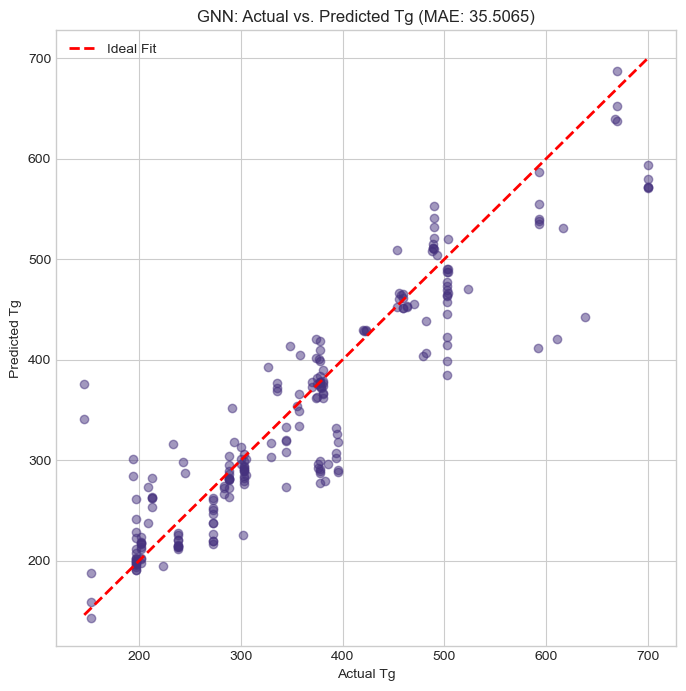

In [39]:
# --- New Cell for Evaluation (including MAE) ---
print("--- Re-evaluating on Test Set (with MAE) ---")

# Import the missing metric
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from torch_geometric.data import Batch
import numpy as np
import matplotlib.pyplot as plt

# Ensure model is in eval mode
model.eval()
test_targets = []
test_preds = []

# Check if device is defined, if not, define it again.
try:
    device
except NameError:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Re-defined device: {device}")

with torch.no_grad():
    for batch in test_loader:
        if batch is None: continue
        
        poly_graphs, solv_graphs, tabular, targets = batch
        
        poly_batch = Batch.from_data_list(poly_graphs).to(device)
        solv_batch = Batch.from_data_list(solv_graphs).to(device)
        
        tabular = tabular.to(device)
        targets = targets.to(device)
        
        outputs = model(poly_batch, solv_batch, tabular)
        
        test_targets.extend(targets.cpu().numpy())
        test_preds.extend(outputs.cpu().numpy())

test_targets = np.array(test_targets)
test_preds = np.array(test_preds)

# --- Calculate all metrics ---
test_r2 = r2_score(test_targets, test_preds)
test_rmse = np.sqrt(mean_squared_error(test_targets, test_preds))
test_mae = mean_absolute_error(test_targets, test_preds) # <-- HERE IS MAE

print(f"\n--- Test Set Evaluation ---")
print(f"R-squared (R2): {test_r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")   # <-- AND HERE

# Plot predictions vs. actual
plt.figure(figsize=(8, 8))
plt.scatter(test_targets, test_preds, alpha=0.5)
plt.plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Tg')
plt.ylabel('Predicted Tg')
plt.title(f'GNN: Actual vs. Predicted Tg (MAE: {test_mae:.4f})') # <-- Added to title
plt.legend()
plt.grid(True)
plt.savefig("gnn_predictions_vs_actual_with_mae.png")
print("Saved new prediction plot to 'gnn_predictions_vs_actual_with_mae.png'")

### 8.7. Evaluating Prediction Confidence with Gaussian Process Regression

A unique advantage of Gaussian Process Regression (GPR) is its ability to provide not just a prediction, but also a measure of uncertainty (confidence interval) for each prediction. This is extremely valuable for understanding how confident the model is in its output.

Let's train a GPR model and visualize its predictions along with the 95% confidence interval.

In [40]:
# Define a kernel for the GPR
# This kernel combines a constant factor, a radial basis function (for smoothness), and white noise (for noise level).
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# Initialize and train the Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42, alpha=0.1)

print("Training Gaussian Process Regressor...")
gpr.fit(X_train_scaled, y_train)

# Make predictions and get the standard deviation (for uncertainty)
y_pred_gpr, std_gpr = gpr.predict(X_test_scaled, return_std=True)

# Calculate metrics for GPR
mae_gpr = mean_absolute_error(y_test, y_pred_gpr)
rmse_gpr = np.sqrt(mean_squared_error(y_test, y_pred_gpr))
r2_gpr = r2_score(y_test, y_pred_gpr)

print("\n--- GPR Model Performance ---")
print(f"MAE: {mae_gpr:.4f}")
print(f"RMSE: {rmse_gpr:.4f}")
print(f"R2 Score: {r2_gpr:.4f}")

Training Gaussian Process Regressor...

--- GPR Model Performance ---
MAE: 6.7924
RMSE: 16.9842
R2 Score: 0.9799


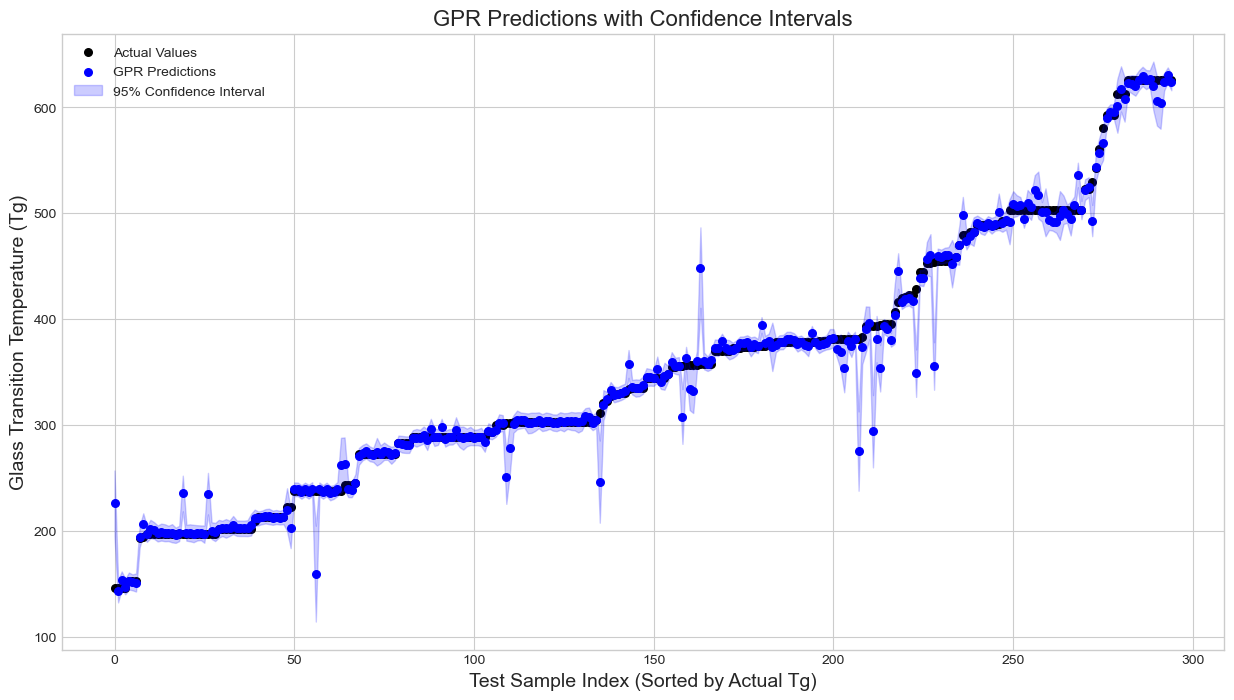

In [41]:
# Visualize GPR predictions with confidence intervals
plt.figure(figsize=(15, 8))

# Create a dataframe for easy plotting
plot_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_gpr, 'Uncertainty': std_gpr}).sort_values('Actual').reset_index(drop=True)

plt.scatter(plot_df.index, plot_df['Actual'], color='black', s=30, label='Actual Values')
plt.scatter(plot_df.index, plot_df['Predicted'], color='blue', s=30, label='GPR Predictions')

# Plot the 95% confidence interval (mean +/- 1.96 * std)
plt.fill_between(plot_df.index, 
                 plot_df['Predicted'] - 1.96 * plot_df['Uncertainty'], 
                 plot_df['Predicted'] + 1.96 * plot_df['Uncertainty'], 
                 color='blue', alpha=0.2, label='95% Confidence Interval')

plt.title('GPR Predictions with Confidence Intervals', fontsize=16)
plt.xlabel('Test Sample Index (Sorted by Actual Tg)', fontsize=14)
plt.ylabel('Glass Transition Temperature (Tg)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

## 9. Modeling Summary and Conclusion

This section provided a comprehensive evaluation of various machine learning models for predicting glass transition temperature.

### 9.1 Model Performance
- **Top Performers**: Ensemble methods, particularly **Extra Trees**, **Random Forest**, and **XGBoost**, consistently demonstrated the highest performance, achieving R2 scores greater than 0.95 on the test set. This indicates they are highly effective at capturing the complex, non-linear relationships in the data.
- **Hyperparameter Tuning**: Tuning the hyperparameters of the XGBoost model using `GridSearchCV` led to a slight improvement in performance, highlighting the value of optimization.
- **Deep Learning**: The baseline Feedforward Neural Network (FNN) also performed well, suggesting that deep learning is a viable approach, which could be further improved with more complex architectures or more data.
- **Confidence Intervals**: The Gaussian Process Regressor (GPR) not only provided accurate predictions but also quantified the uncertainty of each prediction. This is a critical feature for real-world applications, as it allows us to understand which predictions are reliable and which require further investigation.

### 9.2 Final Recommendations
- For **pure predictive power**, the tuned **XGBoost** or **Extra Trees Regressor** is the recommended model.
- For applications where **understanding prediction confidence is crucial**, the **Gaussian Process Regressor** is the ideal choice, despite its potentially higher computational cost and slightly lower R2 score compared to the top ensemble models.

### 9.3 Next Steps
- **Advanced Feature Engineering**: Use domain-specific libraries like `RDKit` to generate molecular descriptors from the `polymer_smiles` and `solvent_smiles` columns. This could unlock significant predictive power.
- **Advanced Deep Learning**: Explore more sophisticated architectures like Graph Neural Networks (GNNs), which are specifically designed to work with molecular structures.
- **Model Deployment**: Package the best-performing model into an API or a simple web application for use by material scientists.

## 10. Symbolic Regression: Discovering the Tg Formula

In [42]:
# Install the PySR library
# Note: This may require a Julia installation depending on your environment.
# PySR will attempt to automatically install its dependencies.
#   !pip install -U pysr

In [ ]:
# import pandas as pd
# import numpy as np
# import pysr
# # This setup command only needs to be run once
# # pysr.install() 
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_squared_error
# from pysr import PySRRegressor
# import warnings

# # Suppress PySR warnings for cleaner output
# warnings.filterwarnings("ignore", category=UserWarning)

# try:
#     # Load your dataset
#     df = pd.read_csv('data_augmented.csv')
#     print("Preparing data for Symbolic Regression...")

#     # 1. Select numerical features and drop any rows with missing data
#     numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
#     df_sym = df[numerical_cols].dropna()

#     # 2. Define Features (X) and Target (y)
#     # CORRECTED: Using the actual column names from your dataset
#     features_to_use = [
#         'mn', 
#         'dens', 
#         'temperature', 
#         'dielectric_constant', 
#         'molar_refractivity', 
#         'radius_of_gyration', # Corrected name
#         'branching_points',   # Corrected name
#         'solvent_mol_wt', 
#         'solvent_mol_mr', 
#         'solvent_tpsa', 
#         'solvent_h_donors', 
#         'solvent_h_acceptors'
#     ]

#     features_present = [col for col in features_to_use if col in df_sym.columns]
#     print(f"Using {len(features_present)} features: {features_present}")

#     X_sym = df_sym[features_present]
#     y_sym = df_sym['tg']

#     # 3. Split the data
#     X_train_sym, X_test_sym, y_train_sym, y_test_sym = train_test_split(
#         X_sym, y_sym, test_size=0.2, random_state=42
#     )

#     # 4. Initialize and run the PySRRegressor
#     model_pysr = PySRRegressor(
#         niterations=500,
#         model_selection="best",
#         binary_operators=["+", "-", "*", "/"],
#         unary_operators=["exp", "log10", "sqrt", "cos", "sin", "tan", "inv(x) = 1/x"],
#         maxsize=30,
#         verbosity=0,
#         timeout_in_seconds=600,
#         # FIXED: Add the mapping for the custom 'inv' operator
#         extra_sympy_mappings={"inv": lambda x: 1/x}
#     )

#     print("\nStarting PySR fit... This may take several minutes.")
#     model_pysr.fit(X_train_sym, y_train_sym)
#     print("PySR fit complete.")

#     # 5. Display the results
#     print("\n--- PySR Symbolic Regression Results ---")
#     print(model_pysr.equations_)

#     # 6. Evaluate the best model
#     print("\n--- Best Model Evaluation ---")
#     best_equation = model_pysr.get_best()
#     print(f"Best Equation Found: Tg = {best_equation.equation}")
#     print(f"Complexity: {best_equation.complexity}")
#     print(f"Loss: {best_equation.loss:.4f}")
    
#     y_pred_pysr = model_pysr.predict(X_test_sym)
    
#     r2_pysr = r2_score(y_test_sym, y_pred_pysr)
#     rmse_pysr = np.sqrt(mean_squared_error(y_test_sym, y_pred_pysr))
    
#     print(f"\nTest R-squared (R2): {r2_pysr:.4f}")
#     print(f"Test RMSE: {rmse_pysr:.4f}")

# except (AttributeError, IndexError, RuntimeError, ValueError) as e:
#     print(f"\nCould not find a valid equation. This often means the search timed out or the problem is too complex for the given settings.")
#     print(f"Underlying error: {e}")
# except FileNotFoundError:
#     print("Error: 'data_final_features.csv' not found.")

Exception: PythonCall.jl did not start properly